# StrandPy Library Overview
**StrandPy is a Python 3 library including Classifiers, Vectorizers, and Feature Selection tools.**
## Vectorizers
* **MinhashVectorizer** - An extension of [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) implementing minhashing. MinhashVectorizer supports all [TfidfVectorizer features](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), adding a new minhashing layer. 
 
 **Novel functionality implemented by MinhashVectorizer also includes:**  
  * MinhashVectorizer is able to retain the feature names of features selected during the minhashing process.
  * It also supports the creation of both binary and non-binary minhashed matrices. For example, capturing how many times a minhash selected feature occured for a minhashed row / gene sequence / document. 
  
* **StrandVectorizer** - An entirely new minhashing vectorizer that can process both text and numeric data for both sparse and dense matrices.  
 * Minhashing is typically used on text data only. The StrandVectorizer transforms both text and numeric data into binary or non-binary mihashed feature bins for machine learning. 

## Classifiers
**All StrandPy classifiers implement a single-threaded version of the patented Strand functionality disclosed [here](https://patents.google.com/patent/US20140222736) and [here](https://patents.google.com/patent/US20140344195).** 
* **StrandSliceClassifier** - A extremely fast and naive Strand sparse matrix based classifier implementing a binary feature voting strategy. 
* **StrandGiniClassifier** - A Strand classifier assuming that selection of a feature as a minhash value is a mutually exclusive event.  The probability of feature selection is determined by (feature count for class / feature count).
* **StrandBinaryClassifier** - A Strand classifier implementing a feature voting strategy which also considers both binary and non-binary feature data provided during classification.
* **StrandNonBinaryClassifier** - **UNDER DEVELOPMENT** A Strand classifier implementing a feature voting strategy which also considers both binary and non-binary feature data provided during training and classification.

## Feature Selection
**StrandPy implements a rapid Cross Validated Feature Selection tool that is optimized for sparse data:**
* **CVFE** - Implements sparse matrix based cross validated feature elimination including the following novel optimizations:
 * Low Nonzero Features - Uses cross validation to eliminates 

# Minhash Vectorizer Overview
* MinhashVectorizer uses the python string__hash() function to randomly select features / columns with non-zero values from each input record / document in a consistent fashion.
* In this case, the term "consistent" means that if two features / columns producing minimum hash values exist in two different input records / documents the MinhashVectorizer would always select those features as part of the minhash signature during the minhashing process.      
* When processing string data, each unique k-mer, word, token, n-gram, noun phrase, or any other chunk of text consistently extracted from documents is considered a feature / column in a giant feature matrix. 
 * In a Binary Matrix, a value of True or False would indicate if the feature exists within each record / document / gene sequence.
 * In a Non-Binary Matrix, a frequency would indicate how many times the feature exists within each record / document / gene sequence. 
 * The values in both Binary and Non-Binary Matrices could also be further transformed using Tf-Idf, L1 / L2 Normalization, IDF Smoothing, Sublinear Tf scaling, among others.   
* A dense feature matrix would include: 
 * One column for each unique feature in a document corpora.  
 * Each row would represent one document. 
 * Each row and column intersection would represent a binary flag, frequency, tfidf value or any other numeric value describing a particular feature within a particular document and document corpus.
 * When a feature did not exist in a record, the dense matrix would still record NA or 0 for all row and column intersections taking up the same amount of space as when the value exists. 
 * This can take up a considerable amount of extra space for sparse data such as text, gene sequences, or columns resulting from one hot encoding.  In such data, only a small percentage of all known features are used within each row / document.  
 
### Minhash Vectorizer Sparse Matrix Output Format
* In practice, most features contained within a given document, gene sequence, or row from a collection of one hot encoded columns will represent a very small fraction (< 1%) of all the unique features found within the document corpora or data table. 
* As a result, the data is stored in a sparse matrix which allows the vectorizer to fit much larger datasets into memory.  
* For example, the RDP gene sequence dataset used below contains 4,786 gene sequences with 807,185 unique k-mers at a length of 20 charcters.  In a dense matrix representation, this dataset would contain 4786 x 807185 = 3,863,187,410 elements / values.  
* When represented as a sparse matrix, the same dataset contains only 6,940,414 elements / values.
### Minhashing Benefits 
* For some massive datasets, a sparse matrix representation is still too large.
* Minhashing the dataset randomly and consistently selects n non-zero features from the matrix, where n is a number provided in the signature_length parameter. 
* Minhashing and the signature_length parameter guarantees that no individual document / record will contain more than n non-zero features.
* This is a form of dimensionality reduction that effectively shrinks the dataset in a consitent manner, ensuring that the same non-zero features producing minimum hash values are selected from each document when they exist. 
* For example, the RDP gene sequence dataset used below contains only 1,196,500 stored elements at a signature length of 250 and 4,784,594 stored elements at a signature length of 1,000.
* Classification accuracy typically increases as the minhash signature length increases.  However, very accurate classification results may be achieved with shorter signature lengths on some datasets.   
### Minhashing Disadvantages
* Minhashing is a form of lossy compression.  You cannot return back to the original dataset using a "minhashed" dataset.
* Both TfidfVectorizer and MinhashVectorizer do not support the transformation of numeric data "out of the box" (i.e. You cannot TfidfVectorize or MinhashVectorize numbers).
* Hash functions can cause collisions.  Likewise, there may be some collisions that occur during minhashing.
* However, since minhashing only impacts which non-zero columns / features are selected from a given document, collisions only impact which features are placed into the minhash signature rather than impacting the underlying data values themselves.   
### Feature Importance
* Typically feature names become obfuscated by thier respective hash values during minhashing.
* However, the MinhashVectorizer() is able to retain feature names during the minhashing process.  
* This means that the resulting sparse matrix contains a list of all the unique feature names selected during minhashing and which feature names were selected for a particular row within the minhash signature. 

## MinhashVectorizer and the PYTHONHASHSEED
* Since the Python 3 string__hash() function is randomly seeded for each new Python 3 session, we need to override this behavior when using the MinhashVectorizer.
* Otherwise, the non-zero features randomly selected during fitting and transformations will be different when advanced Python / scikit learn features such as Pipelines are used during cross validation. 
* We could easily implement our own un-seeded hashing function for the MinhashVectorizer.  However, the Python 3 string__hash() function is implemented in C. So, we would take a big performance hit.  
* Implementing an un-seeded hashing function in C specifically for MinhashVectorizer may be worth exploring. 
* Even when using PYTHONHASHSEED, the behavior is inconsistent between individual Python 3 sessions. 
 * Total number of elements selected from minhashing will remain the same across sessions when using the same parameters.
 * The features selected as minimum hash values for each row will change, since the hash seed changes between sessions.  
 * The total number of unique features will also change between sessions for the same data.
 * The data selected between sessions will still be minhashed properly, a representative sample, and perform with similar accuracy results during cross validation. 
 * Each session's data will just represent a different random selection dur to the randomly seeded hash function.
* **WORKAROUND:** You can easily save and read any minhashed sparse datasets to .npz files using .save_npz() and .load_npz()  
 * This feature allows you to use the same minhashed dataset across any number of sesssions when required.

In [1]:
%env PYTHONHASHSEED=42

env: PYTHONHASHSEED=42


### Load the RDP Test Dataset (A gene sequence .fasta dataset)

In [2]:
import pandas as pd
import numpy as np

def read_fasta_file(file_path):
    X = []
    y = []
    with open(file_path, 'r') as dat:
        for line in dat.readlines():
            #print(line)
            if line[0] == '>':
                g_start = line.find("g__")
                g_end = line.find(";", g_start)
                genus = line[g_start:g_end]
                y.append(genus)
            else:
                X.append(line)
    return X, y

import pandas as pd

# Read in the fasta file
X, y = read_fasta_file('D:/StrandPy/Data/RDP_All_Clean.strand')
#Remove low count genera that halt cross validation
data = {'X': X,'y':y}
df = pd.DataFrame(data)

#Inspect counts for each class
vcts = df.y.value_counts()
low_vcts = vcts[vcts < 20].index.values

#Remove low count genera. Any classes < the fold count will halt cross validation
df = df[~df.y.isin(low_vcts)]

# Create X and y
X = df.X.values
y = df.y.values

print('File Size: ' + str(len(X)))
print('Longest Sequence Chars:' + str(len(max(X, key=len))))

File Size: 4786
Longest Sequence Chars:1834


### What Does the Data Look Like?

In [2]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(X, y).head()

,0
g__Paenibacillus,TCGAGGGGAGCTAGAGTTTTATTAATCCCGGAAATCCACTGANACTTTAGCGGCGGACGGGTGAGTAACACGTAGGTAACCTGCCCATAAGACCGGGATAACATTCGGAAACGGATGCTAATACCCGGATACGCGATTCTCTCGCATGAGAGAAGTTGGGAAAGGCGGAGCAATCTGTCACTTATGGATGGACATGCGGCGCATTAGCTAGTTGGTGAGGTAACGGCTCACCAAGGAGATGATGTGTAGCCCACGTGACAGGGTGATCGGCCACACTGGGNCAGAGACACGGCCCAGACTCTGACGGGAGGCAGCAGTAGGGAATCTTCCGCAATGGAAGAAAATCTGACGGAGCAACGCCGCCTGAGTGATGAAGGTTTTCGGATCGAAAAGCTCTGTTGCCAGGGAAGAACGCTAGAGAGAGTAACTGCTCTTTAGGTGACGGTACCTGAGAAGAAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTTGATTAAGTCTGGTGTTTAAGGCTATGGCTCAACCATAGTTCGCACTGGAAACTGGTTGAATTGAGTGCAGAAGAGGAAAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGGCGGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGAATGCTAGGTGTTAGGGGTTTCGATACCCTTGGTGCCGAAGTTAACACATTAAGCATTCCGCCTGGGGAGTACGGTCGCAAGACTGAAACTCAAAGGAATTGACGGGGACCCGCACAAGCAGTGGAGTATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATGCCTCTGACCGCTCTAGAGATAGAGCTTCTCTTCGGAGCAGGGGACACAGGTGGTGCATGGTTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCTGCAACGAGCGCAACCCCTAATGTTAGTTGCCAGCAGGTAGAGCTGGGCACTCTAACGTGACTGCCGGTGACAAACCGGAGGAAGGTGGGGATGACGTCAAATCATCATGCCCCTTATGACCTGGGCTACACACGTACTACAATGGCCAGTACAACGGGAAGCGAAGTCGCGAGATGGAGCCAATCCTCAAAAGCTGGTCTCAGTTCGGATTGCAGGCTGCAACTCGCCTGCATGAAGTCGGAATTGCTAGTAATCGCGGATCAGCATGCCGCGGTGAATACGTTCCCGGGTCTTGTACACACCGCCCGTCACACCACGAGAGTTTACAACACCCGAAGCCGGTGGGGTAACCCGCAAGGGAGCCAGCCGTCGAAGGTGGGGTAGATGATTGGGGTGAAGTCGTAT\n
g__Propionibacterineae,AGGACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGGTAAGGCCTTTCGGGGTCATACGAGTGGCGAACGGGTGAGTAACACGTGAGCAACCTGCCCTTGACTTCGGAATACCAGCTGGAAACAGCTGCTAATACCGGATATGACCCTGGTCCTCCTGGACTGGGGTGGAAAGCTCCGGCGGTCAGGGATGGGCTCGCGGCCTATCAGCTTGTTGGTGAGGTAATGGCTCACCAAGGCTTCGACGGGTAGCCGGCCTGAGAGGGCGACCGGCCACACTGGGACTGAGATACGGCCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCAACGCCGCGTGCGGGATGACGGCCTTCGGGTTGTAAACCGCTTTCAGTAGGGACGAAGCCACAAGTGACGGTACCTACAGAAGAAGGACCGGCTAACTACGTGCCAGCAGCCGCGGTGATACGTAGGGTCCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTTGTAGGCGGTCCGTCGCGTCAGGAGTGAAAACTCGGGGCTTAACCCCGAGCCTGCTTTTGATACGGGCGGACTAGAGGGATGCAGGGGAGAACGGAATTCCTGGTGGAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGTTCTCTGGGCATCACCTGACGCTGAGAAGCGAAAGCGTGGGGAGCAAACAGGCTTAGATACCCTGGTAGTCCACGCCGTAAACGGTGGGCACTAGGTGTGGGGGACATTCCACGTTCTCCGTGCCGAAGCTAACGCATTAAGTGCCCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGGTTTGACATACACCGGAAAGCTGCAGAGATGTAGCCCCCGCAAGGTCGGTGTACAGGTGGTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTCGTTCTATGTTGCCAGCACGTCATGGTGGGGACTCATAGGAGACTGCCGGGGTCAACTCGGAGGAAGGTGGGGATGACGTCAAGTCATCATGCCCCTTAAGTCCAGGGCTTCACGCATGCTACAATGGCCGGTACAAAGGGCTGCGATACCGCAAGGTGGAGCGAATCCCAAAAAGCCGGTCTCAGTTCGGATTGGGGTCTGCAACTCGACCCCATGAAGTCGGAGTCGCTAGTAATCGCAGATCAGCAACGCTGCGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCAAGTCATGAAAGTCGGTAACACCCGAAGCCGGTGGCCCAACCCTTGTGGAGGGAGCCGTCTAAGGTGGGACTGGCGATTAGGACTAAGTCGTAACAAGGTAGCCGTACCGGAAGGT\n
g__Coriobacterineae,CGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAATAACCCGCCTTCGGGCGGTCATAGAGTGGCGAACGGGTGAGTAACACGTGACCAACCTTCCCCCCGCATGGGGATAACCGGGCGAAAGCCCGGCTAATACCCAATACTCCGGGCCCTCCGCATGGAGGGGCCGGGAAAGCCCAGGCGGCGGGGGATGGGGTCGCGGCCCATTAGGTAGACGGCGGGGTAACGGCCCACCGTGCCCGCGATGGGTAGCCGGACTGAGAGGTCGATCGGNCACATTGGGACTGAGATACGGCCCAGACTCCTACGGGAGGCAGCAGTGGGNAATTTTNCGCNATGGGNNAAACCCTGACGCNGCNACGCCGCGTGCGGGATGAAGGCCCTAGGGTTGTAANCCNCTTTCNGCNGGGAAGAAACNTGACGGNACCTGCAGAAGAAGCTCCGNCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGAGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCTGNCCAANCGGGATCTCANATCCGGGGGCTCAACCTCCGGCCGGATCCCGAACTGNCCGGCTCGAGTTCGGTAGAGGAAGACGGAATTCCCAGTGTAGCGGTGNAATNCGCAGATATTGGGAAGAACACCGATGNCGAAGGCAGTCTTCTGGGCCNCGACTGACNCTGAGGTGCGAAAGCCGGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCCGNCCGTAAACGATGGGCACTAGGTGTGGGGGAGCCTTTCCTCCGCGCCGCAGCTAACGCATTAAGTGCCCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCAGCGGAGCATGTGGNTTAATTCGAAGCAACGCGAAGAACCTTACCAGGGCTTGACATGCGGGTGAAGCCGGGGAAACCCGGTGGCCGAGAGGAGCCCGCGCAGGTGGTGNATGGCTG

## MinhashVectorizer Compared with TfidfVectorizer
* Vectorizing the RDP file using TfidfVectorizer stores 6,940,414 elements and takes ~8.79 seconds.
* Vectorizing the RDP file using MinhashVectorizer stores 1,196,500 elements and takes ~5.69 seconds at a signature length of 250.
* Vectorizing the RDP file using MinhashVectorizer stores 4,784,594 elements and takes ~11.1 seconds at a signature length of 1000.

In [3]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_tfidf = tfidf.fit_transform(X)
X_tfidf

Wall time: 8.79 s


<4786x807185 sparse matrix of type '<class 'numpy.float64'>'
	with 6940414 stored elements in Compressed Sparse Row format>

In [4]:
%%time
from StrandPy import MinhashVectorizer
mhv = MinhashVectorizer(signature_length=250, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv = mhv.fit_transform(X)
X_mhv

Wall time: 5.69 s


<4786x143336 sparse matrix of type '<class 'numpy.float64'>'
	with 1196500 stored elements in Compressed Sparse Row format>

In [5]:
%%time
mhv2 = MinhashVectorizer(signature_length=1000, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv2 = mhv2.fit_transform(X)
X_mhv2

Wall time: 11.1 s


<4786x568032 sparse matrix of type '<class 'numpy.float64'>'
	with 4784594 stored elements in Compressed Sparse Row format>

## Feature Importance Analisys
* Typically feature names become obfuscated by thier respective hash values during minhashing.
* However, the MinhashVectorizer() is able to retain feature names during the minhashing process.  
* This means that the resulting sparse matrix contains a list of all the unique feature names selected during minhashing and which feature names were selected for a particular document / row's minhash signature. 
* This is critical since we can use feature names to perform feature importance analisys for many classifiers and also feature ranking algorithms such as recursive feature elimination. 

### Below, the RDP test dataset is minhashed using a signature_length of 50 features
* We can see that there are 4786 (rows) x 29733 (columns) and 239,300 data values stored. 
* Each row starts out as a gene sequence that is broken into k-mers of length 20.
* All k-mers are hashed and sorted, including duplicates. 
* Since a signature length of 50 is used, each row contains the first 50 non-zero features producing minimum hash values in a given document.
* There are also 28,350 unique features observed in the document corpora ( all documents processed furing fit() ).
* Only 50 of these 28,350 unique features will have a value > 0 for any given document in the document corpora after minhashing.  

In [6]:
%%time
mhv50 = MinhashVectorizer(signature_length=50, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv50 = mhv50.fit_transform(X)
X_mhv50

Wall time: 4.65 s


<4786x29733 sparse matrix of type '<class 'numpy.float64'>'
	with 239300 stored elements in Compressed Sparse Row format>

### Inspecting Feature Names after Fitting
* We can see that MinhashVectorizer() has a total of 28,350 features.
* Inspecting the first 10 features, we can also see that these are k-mers of length 20, rather than hash codes. 

In [7]:
print('Total Feature Names: ', len(mhv50.get_feature_names()))
mhv50.get_feature_names()[0:10]

Total Feature Names:  29733


['aaaaaaccgttctcagttcg',
 'aaaaacaggtcccagttcgg',
 'aaaaacccagtcccagttcg',
 'aaaaaccgcatggtttttgt',
 'aaaaacctctctcagttcgg',
 'aaaaacgtgcccantggant',
 'aaaaagccatctcagttcgg',
 'aaaaagccgtcccagtccgg',
 'aaaaagtcagtctcagtccg',
 'aaaaagtcgaggaggaaatg']

### Looking at One Document:
**After minhashing / fitting, we can see that the first document contains only 50 non-zero values / elements:**
 

In [9]:
X_mhv50[0,:]

<1x29733 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

**It is easy to inspect which features / columns were selected in the minhash signature for row 0:**

In [10]:
X_mhv50[0,:].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 array([ 2083, 16967, 18613, 22961,   153,  1913, 15332, 21373,  7380,
         2218, 17494, 19082, 29470, 15041, 10563,   823, 21030, 15329,
        26364, 13281, 22615,  8860, 26443,  3380, 22843,  5376, 12769,
        23940, 23179,  2783, 26228,   491,  5076,  9169, 26138, 24974,
        21077,  4041,  1542,  6246, 17844, 21782,  8412, 21179,  3324,
         3162, 22374,  5707, 27852,  3493]))

**We can also see the feature names (individual k-mers in this case) for each feature in the minhash signature:**  

In [11]:
# Get all of the feature names
f_names = mhv50.get_feature_names()
# Use list comprehension to look up feature names for each 
# non-zero column in the first document's minhash signature 
[f_names[c_idx] for c_idx in X_mhv50[0,:].nonzero()[1]]

['aattgacggggacccgcaca',
 'gcagtggagtatgtggttta',
 'ggaaacggatgctaataccc',
 'gttcggattgcaggctgcaa',
 'aaacggatgctaatacccgg',
 'aatcgcggatcagcatgccg',
 'gacggggacccgcacaagca',
 'ggttttcggatcgaaaagct',
 'attgacggggacccgcacaa',
 'acaccacgagagtttacaac',
 'gcctctgaccgctctagaga',
 'ggagtacggtcgcaagactg',
 'tttcggatcgaaaagctctg',
 'gaattgagtgcagaagagga',
 'cctggggagtacggtcgcaa',
 'aacgggaagcgaagtcgcga',
 'ggtcttgacatgcctctgac',
 'gacgggaggcagcagtaggg',
 'tgaatgctaggtgttagggg',
 'ctctgacgggaggcagcagt',
 'gtggcgaaggcgactttctg',
 'catgaagtcggaattgctag',
 'tgaccgctctagagatagag',
 'acgtaggtaacctgcccata',
 'gttaacacattaagcattcc',
 'aggtgttaggggtttcgata',
 'ctaatacccggatacgcgat',
 'tacaatggccagtacaacgg',
 'gtttcgatacccttggtgcc',
 'accggaggaaggtggggatg',
 'tctttaggtgacggtacctg',
 'aacaccagtggcgaaggcga',
 'aggcggttgattaagtctgg',
 'ccaatcctcaaaagctggtc',
 'tctgtcacttatggatggac',
 'tcaaatcatcatgcccctta',
 'ggtgatcggccacactgggn',
 'agagatagagcttctcttcg',
 'aagtccctgcaacgagcgca',
 'atagttcgcactggaaactg',


**Finally, we can get the column index of the first feature, if needed:**

In [13]:
mhv50._tfidf.vocabulary_['aattgacggggacccgcaca']

2083

## Compare Several Classifiers Using Sklearn's Stratified Cross Validation 
**The MinhashVectorizer is an Sklearn compliant Transformer.  This means that it can easily work "out of the box" with other Sklearn tools such as cross validation, grid search, and pipelines.  In the following example, we:**
* Use the minhash vectorized dataset to build models Strand and five other Sklearn classifiers.   
* Perform stratified 10-fold cross validation using Sklearn's StratifiedKFold cross validator.
* Run cross validation in Parallel using Sklearn's cross_validate function running on all cores. 
* Use 90% of the data for training  
* Use 10% of the data for testing
* Score each classifier's cross validation using the accuracy metric.  There are 18 different classification metrics we could have chosen to use with cross_validate here.  In addition, we could have created our own custom scorer to use as well.  

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return

## Comparing Classifiers
**I have selected several Sklearn classifiers that will support multi-class, sparse datasets and run in a reasonable period of time including:** 
* MultinomialNB()
* SGDClassifier() using linear SVM
* RandomForestClassifier()
* LinearSVC()
* LogisticRegression()

**These classifiers are compared to the StrandPy Classifiers including:**
* StrandSliceClassifier
* StrandGiniClassifier
* StrandBinaryClassifier

**I compare all classifers using RDP Test dataset and k-mers of length 20 using:**
* TfidfVectorizer
* MinhashVectorizer @ a minhash signature length of 50
* MinhashVectorizer @ a minhash signature length of 100
* MinhashVectorizer @ a minhash signature length of 250
* MinhashVectorizer @ a minhash signature length of 1000

In [4]:
# Sklearn Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
# StrandPy Classifiers
from StrandPy import StrandSliceClassifier
from StrandPy import StrandGiniClassifier
from StrandPy import StrandBinaryClassifier


models = [
    StrandSliceClassifier(), 
    StrandGiniClassifier(),
    StrandBinaryClassifier(),
    MultinomialNB(),
    SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42),
    LinearSVC(random_state=42),
    LogisticRegression(random_state=42)
]

model_names = ['StrandSliceClassifier','StrandGiniClassifier','StrandBinaryClassifier','MultinomialNB','SGDClassifier',
               'RandomForestClassifier','LinearSVC','LogisticRegression']


def test_models(X, y):
    for model, model_name in zip(models,model_names):
        print(model_name)
        print('--------------------------------')
        stratified_cross_validate(model,X,y)
        print(' ')

### Test Classifiers using TfidfVectorizer
* All classifiers are tested against the RDP dataset using Sklearn's TfidfVectorizer().
* The RDP dataset is vectorized into k-mers of length 20 which are counted.
* No tfidf, normalization, or smoothing are applied.
* Classifiers tested include the StrandPy's Slice, Gini and Binary Classifiers.
* These classifiers are optimized for classifying Minhash and Strand Vectorized Data.
* Note the fit, score, and Cv times below which reflect total times for various aspects of these stratified, 10-fold cross validations for each individual model.  

In [17]:
%%time
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_tfidf = tfidf.fit_transform(X)
X_tfidf

Wall time: 8.77 s


<4786x807185 sparse matrix of type '<class 'numpy.float64'>'
	with 6940414 stored elements in Compressed Sparse Row format>

In [18]:
test_models(X_tfidf, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99164927 0.99582463 0.99582463 0.99582463 0.99791232
 0.9958159  0.9958159  0.99372385 1.        ]
 
Mean Accuracy:  0.9956128091124292
Mean Fit Time:  0.8757014989852905
Mean Score Time:  0.7918919801712037
CV Time:  5.1037373542785645
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.98538622 0.98329854 0.98956159 0.98956159 0.9874739  0.98956159
 0.99790795 0.9832636  0.9832636  0.99372385]
 
Mean Accuracy:  0.9883002419615481
Mean Fit Time:  14.006837224960327
Mean Score Time:  10.388650584220887
CV Time:  41.83902645111084
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99164927 0.99582463 0.99582463 0.99582463 0.99791232
 0.9958159  0.9958159  0.99372385 1.        ]
 
Mean Accuracy:  0.9956128091124292
Mean Fit Time:  14.352577137947083
Mean Score Time:  7.146070289611816
CV Time:  35.8212411403656
 
MultinomialNB
---------------------

### Test Classifiers using MinhashVectorizer @ 50
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 50
* The RDP dataset is vectorized into k-mers of length 20 which are counted.
* No tfidf, normalization, or smoothing are applied.
* Classifiers tested include the Strand Binary and NonBinary Classifiers.
* These classifiers are optimized for classifying Minhash and Strand Vectorized Data.

In [19]:
%%time
mhv50 = MinhashVectorizer(signature_length=50, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv50 = mhv50.fit_transform(X)
X_mhv50

Wall time: 25.6 s
Parser   : 299 ms


<4786x29733 sparse matrix of type '<class 'numpy.float64'>'
	with 239300 stored elements in Compressed Sparse Row format>

In [20]:
test_models(X_mhv50, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.99164927 0.99164927 0.99164927 0.99582463 0.98956159 0.99582463
 0.99372385 0.98953975 0.98953975 0.99790795]
 
Mean Accuracy:  0.9926869960954219
Mean Fit Time:  0.3414654016494751
Mean Score Time:  0.1367797374725342
CV Time:  7.121617794036865
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.97912317 0.97703549 0.97912317 0.98329854 0.97703549 0.97912317
 0.99372385 0.97698745 0.98535565 0.9707113 ]
 
Mean Accuracy:  0.9801517282343795
Mean Fit Time:  0.42863514423370364
Mean Score Time:  0.27215626239776614
CV Time:  4.07963490486145
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.99164927 0.99164927 0.99164927 0.99582463 0.98956159 0.99582463
 0.99372385 0.98953975 0.98953975 0.99790795]
 
Mean Accuracy:  0.9926869960954219
Mean Fit Time:  0.39969358444213865
Mean Score Time:  0.2156224727630615
CV Time:  1.060166835784912
 
MultinomialNB
------------------

### Test Classifiers using MinhashVectorizer @ 100
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 100
* The RDP dataset is vectorized into k-mers of length 20 which are counted.
* No tfidf, normalization, or smoothing are applied.
* Classifiers tested include the Strand Binary and NonBinary Classifiers.
* These classifiers are optimized for classifying Minhash and Strand Vectorized Data.

In [21]:
%%time
mhv100 = MinhashVectorizer(signature_length=100, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv100 = mhv100.fit_transform(X)
X_mhv100

Wall time: 5.89 s


<4786x57411 sparse matrix of type '<class 'numpy.float64'>'
	with 478600 stored elements in Compressed Sparse Row format>

In [22]:
test_models(X_mhv100, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.99164927 0.99373695 0.99164927 0.99373695 0.99164927 0.99791232
 0.9958159  0.9958159  0.9916318  0.99790795]
 
Mean Accuracy:  0.9941505577344711
Mean Fit Time:  0.14437952041625976
Mean Score Time:  0.08788890838623047
CV Time:  0.41681599617004395
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.97912317 0.97703549 0.98329854 0.9874739  0.98329854 0.98329854
 0.99372385 0.9832636  0.98117155 0.9790795 ]
 
Mean Accuracy:  0.9830766677439924
Mean Fit Time:  0.950512146949768
Mean Score Time:  0.6677090644836425
CV Time:  2.8606722354888916
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.99164927 0.99373695 0.99164927 0.99373695 0.99373695 0.99791232
 0.9958159  0.9958159  0.9916318  0.99790795]
 
Mean Accuracy:  0.9943593260016946
Mean Fit Time:  0.8671156167984009
Mean Score Time:  0.43750581741333006
CV Time:  2.1758153438568115
 
MultinomialNB
--------------

### Test Classifiers using MinhashVectorizer @ 250
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 250
* The RDP dataset is vectorized into k-mers of length 20 which are counted.
* No tfidf, normalization, or smoothing are applied.
* Classifiers tested include the Strand Binary and NonBinary Classifiers.
* These classifiers are optimized for classifying Minhash and Strand Vectorized Data.

In [23]:
%%time
mhv250 = MinhashVectorizer(signature_length=250, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv250 = mhv250.fit_transform(X)
X_mhv250

Wall time: 11.6 s


<4786x143336 sparse matrix of type '<class 'numpy.float64'>'
	with 1196500 stored elements in Compressed Sparse Row format>

In [24]:
test_models(X_mhv250, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99373695 0.99164927 0.99582463 0.99373695 0.99791232
 0.9958159  0.9958159  0.99372385 1.        ]
 
Mean Accuracy:  0.9951952725779825
Mean Fit Time:  0.20821666717529297
Mean Score Time:  0.12408537864685058
CV Time:  0.5985853672027588
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.98329854 0.97912317 0.98956159 0.99164927 0.98538622 0.98956159
 0.99790795 0.98535565 0.98535565 0.9874477 ]
 
Mean Accuracy:  0.9874647321389576
Mean Fit Time:  2.3755683660507203
Mean Score Time:  1.696353793144226
CV Time:  6.884950160980225
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99373695 0.99164927 0.99582463 0.99373695 0.99791232
 0.9958159  0.9958159  0.99372385 1.        ]
 
Mean Accuracy:  0.9951952725779825
Mean Fit Time:  2.2723144769668577
Mean Score Time:  1.0820468425750733
CV Time:  5.837669610977173
 
MultinomialNB
------------------

### Test Classifiers using MinhashVectorizer @ 1000
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 1000
* The RDP dataset is vectorized into k-mers of length 20 which are counted.
* No tfidf, normalization, or smoothing are applied.
* Classifiers tested include the Strand Binary and NonBinary Classifiers.
* These classifiers are optimized for classifying Minhash and Strand Vectorized Data.

In [25]:
%%time
mhv1000 = MinhashVectorizer(signature_length=1000, analyzer='char', ngram_range=(20,20), binary=False, use_idf=False, norm=None)
X_mhv1000 = mhv1000.fit_transform(X)
X_mhv1000

Wall time: 23.4 s
Parser   : 208 ms


<4786x568032 sparse matrix of type '<class 'numpy.float64'>'
	with 4784594 stored elements in Compressed Sparse Row format>

In [26]:
test_models(X_mhv1000, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99582463 0.99582463 0.99582463 0.99582463 0.99582463
 0.9958159  0.9958159  0.99372385 0.99790795]
 
Mean Accuracy:  0.995612372358732
Mean Fit Time:  0.5622330904006958
Mean Score Time:  0.5203154802322387
CV Time:  2.6907591819763184
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.98538622 0.98329854 0.98956159 0.98956159 0.9874739  0.98956159
 0.9958159  0.98535565 0.9832636  0.99372385]
 
Mean Accuracy:  0.9883002419615483
Mean Fit Time:  9.889858818054199
Mean Score Time:  7.251016330718994
CV Time:  29.266679763793945
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.99373695 0.99582463 0.99582463 0.99582463 0.99582463 0.99582463
 0.9958159  0.9958159  0.99372385 0.99790795]
 
Mean Accuracy:  0.995612372358732
Mean Fit Time:  9.728548789024353
Mean Score Time:  4.926627492904663
CV Time:  24.478174448013306
 
MultinomialNB
-----------------------

In [8]:
%%html
<!-- Align all tables left-->
<style>
table {
       table-layout: fixed;
       width: 100%;
      } 
</style>

## Classification Comparison Results  

### TfidfVectorizer Outputs
* 4786 rows
* 807,185 feature columns
* 6,940,414 stored data elements

### Classifier Rankings - TfidfVectorizer 

|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
StrandSliceClassifier|5.1|1|0.88|1|0.79|2|99.56|1|1.25|
MultinomialNB|13.89|2|7.47|3|0.97|4|98.06|6|3.75|
StrandBinaryClassifier|35.82|4|14.35|5|7.15|6|99.56|1|4|
LinearSVC|674.37|7|472.43|7|0.28|1|99.56|1|4|
SGDClassifier|69.82|6|45.79|6|0.93|3|99.37|4|4.75|
RandomForestClassifier|28.55|3|6.13|2|11.71|8|54.07|7|5|
StrandGiniClassifier|41.84|5|14.01|4|10.39|7|98.83|5|5.25|
LogisticRegression|10750.01|9|3476.65|8|2.59|5|NaN|8|7.5|

### MinhashVectorizer Outputs  @ Signature Length 1000:
* 4786 rows
* 568,032 feature columns
* 4,784,594 stored data elements


### Classifier Rankings - MinhashVectorizer @ Signature Length 1000


|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
StrandSliceClassifier|2.69|1|0.56|1|0.52|5|99.56|2|2.25|
RandomForestClassifier|8.83|2|4.65|3|0.52|3|98.06|6|3.5|
StrandBinaryClassifier|24.48|4|9.73|4|4.93|6|99.56|2|4|
LinearSVC|279.31|7|196.33|7|0.18|2|99.58|1|4.25|
MultinomialNB|17.01|3|4.51|2|6.04|7|53.51|7|4.75|
SGDClassifier|37.06|6|24.36|6|0.52|4|99.44|4|5|
StrandGiniClassifier|29.27|5|9.89|5|7.25|8|98.83|5|5.75|
LogisticRegression|1182.6|8|293.04|8|0.12|1|NaN|8|6.25|

### MinhashVectorizer Outputs  @ Signature Length 500:
* 4786 rows
* 143,336 feature columns
* 1,196,500 stored data elements


### Classifier Rankings - MinhashVectorizer @ Signature Length 500


|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
StrandSliceClassifier|0.6|1|0.21|1|0.12|4|99.52|3|2.25|
MultinomialNB|2.02|2|1.06|2|0.11|2|98.04|7|3.25|
LinearSVC|53.9|7|38.2|7|0.03|1|99.54|2|4.25|
StrandBinaryClassifier|5.84|4|2.27|4|1.08|7|99.52|3|4.5|
SGDClassifier|5.97|5|3.68|6|0.12|3|99.46|5|4.75|
RandomForestClassifier|5.05|3|1.97|3|0.94|6|52.9|8|5|
LogisticRegression|997.75|8|673.11|8|0.22|5|99.58|1|5.5|
StrandGiniClassifier|6.88|6|2.38|5|1.7|8|98.75|6|6.25|

### MinhashVectorizer Outputs  @ Signature Length 250:
* 4786 rows
* 143,336 feature columns
* 1,196,500 stored data elements


### Classifier Rankings - MinhashVectorizer @ Signature Length 250


|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
StrandSliceClassifier|0.6|1|0.21|1|0.12|4|99.52|3|2.25|
MultinomialNB|2.02|2|1.06|2|0.11|2|98.04|7|3.25|
LinearSVC|53.9|7|38.2|7|0.03|1|99.54|2|4.25|
StrandGiniClassifier|5.84|4|2.27|4|1.08|7|99.52|3|4.5|
SGDClassifier|5.97|5|3.68|6|0.12|3|99.46|5|4.75|
RandomForestClassifier|5.05|3|1.97|3|0.94|6|52.9|8|5|
LogisticRegression|997.75|8|673.11|8|0.22|5|99.58|1|5.5|
StrandBinaryClassifier|6.88|6|2.38|5|1.7|8|98.75|6|6.25|

### MinhashVectorizer Outputs  @ Signature Length 100:
* 4786 rows
* 57,411 feature columns
* 478,600 stored data elements


### Classifier Rankings - MinhashVectorizer @ Signature Length 100


|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
StrandSliceClassifier|0.42|1|0.14|1|0.09|5|99.42|5|3|
SGDClassifier|2.29|4|1.3|5|0.05|2|99.52|3|3.5|
MultinomialNB|0.8|2|0.41|2|0.05|3|97.81|7|3.5|
LinearSVC|12.29|7|8.07|7|0.01|1|99.54|2|4.25|
StrandBinaryClassifier|2.18|3|0.87|3|0.44|7|99.44|4|4.25|
LogisticRegression|388.23|8|260.52|8|0.06|4|99.58|1|5.25|
StrandGiniClassifier|2.86|6|0.95|4|0.67|8|98.31|6|6|
RandomForestClassifier|2.83|5|1.36|6|0.22|6|49.9|8|6.25|

### MinhashVectorizer Outputs  @ Signature Length 50:
* 4786 rows
* 29,733 feature columns
* 239,300 stored data elements


### Classifier Rankings - MinhashVectorizer @ Signature Length 50


|Classifier Name         | Cv Time | Rank | Fit Time | Rank | Score Time | Rank | Accuracy | Rank | Rank Sum |
|:--                     |     ---:| :---:|      ---:| :---:|        ---:|------|      ---:| :---:|     :---:|
MultinomialNB|0.44|1|0.21|1|0.03|3|97.47|7|3|
SGDClassifier|1.46|3|0.81|5|0.02|2|99.41|3|3.25|
LinearSVC|5.12|6|3.24|7|0|1|99.5|2|4|
StrandBinaryClassifier|1.06|2|0.4|3|0.22|7|99.27|4|4|
StrandSliceClassifier|7.12|7|0.34|2|0.14|6|99.27|4|4.75|
LogisticRegression|199.86|8|133.73|9|0.04|4|99.52|1|5.5|
StrandGiniClassifier|4.08|5|0.43|4|0.27|8|98.02|6|5.75|
RandomForestClassifier|2.6|4|1.13|6|0.1|5|47.28|8|5.75|







## Parameter Optimization using Pipeline and Grid Search  
* Here a Pipeline is used to perform parameter optimization for the MinhashVectorizer and StrandSliceClassifier.
* The grid search executes in parallel performing stratified 10-fold cross validation for each combination of parameters in the parameter grid. 
* 1,200 10-fold cross validations are performed for a total of 12,000 fits.
* The grid search identifies the highest cross validation accuracy so far of 96.6448% using the following MinhashVectorizer parameters:
 * binary: False, 
 * ngram_range: (30, 30)
 * norm: 'l2' 
 * signature_length: 500
 * sublinear_tf: True
 * use_idf': False
 * smooth_idf: False

In [27]:
# Sklearn  
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# StrandPy  
from StrandPy import MinhashVectorizer
from StrandPy import StrandSliceClassifier

# Set up our cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([
    ('MHV', MinhashVectorizer(analyzer='char')),
    ('Strand', StrandSliceClassifier())
])

param_grid = [
    {
        'MHV__signature_length': [50,100,250,500,1000],
        'MHV__ngram_range': [(15,15),(20,20),(30,30),(60,60),(80,80)],
        'MHV__binary': [True, False],
        'MHV__use_idf': [True,False],
        'MHV__norm': ['l1','l2',None],
        'MHV__smooth_idf': [True,False],
        'MHV__sublinear_tf': [True,False],
    }]

grid_search = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('MHV',
                                        MinhashVectorizer(analyzer='char',
                                                          binary=False,
                                                          decode_error='strict',
                                                          dtype=<class 'numpy.float64'>,
                                                          encoding='utf-8',
                                                          input='content',
                                                          lowercase=True,
                                                          max_df=1.0,
                                                          max_features=None,
                                                          min_df=1,
                                            

In [28]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('MHV',
                 MinhashVectorizer(analyzer='char', binary=True,
                                   decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, max_df=1.0,
                                   max_features=None, min_df=1,
                                   ngram_range=(30, 30), norm='l2',
                                   preprocessor=None, signature_length=500,
                                   smooth_idf=True, stop_words=None,
                                   strip_accents=None, sublinear_tf=False,
                                   token_pattern='(?u)\\b\\w\\w+\\b',
                                   tokenizer=None, transform_inplace=False,
                                   use_idf=False, vocabulary=None)),
                ('Strand',
                 StrandSliceClassifier

In [29]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9964483189350197

In [30]:
print('Total Grid Searches: ', len(grid_search.cv_results_['params']))

Total Grid Searches:  1200


In [31]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
print('All Grid Search Results\n')
data = {'params': grid_search.cv_results_['params'], 'mean_test_score': grid_search.cv_results_['mean_test_score'] }
df = pd.DataFrame(data)
df.sort_values(['mean_test_score'],ascending=False)[0:100]

All Grid Search Results



,params,mean_test_score
307,"{'MHV__binary': True, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 500, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': False, 'MHV__use_idf': False}",0.996448
909,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 500, 'MHV__smooth_idf': False, 'MHV__sublinear_tf': True, 'MHV__use_idf': False}",0.996448
914,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 1000, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': False, 'MHV__use_idf': True}",0.996240
351,"{'MHV__binary': True, 'MHV__ngram_range': (30, 30), 'MHV__norm': None, 'MHV__signature_length': 500, 'MHV__smooth_idf': False, 'MHV__sublinear_tf': False, 'MHV__use_idf': False}",0.996240
906,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 500, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': False, 'MHV__use_idf': True}",0.996240
916,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 1000, 'MHV__smooth_idf': False, 'MHV__sublinear_tf': True, 'MHV__use_idf': True}",0.996240
871,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l1', 'MHV__signature_length': 500, 'MHV__smooth_idf': False, 'MHV__sublinear_tf': False, 'MHV__use_idf': False}",0.996240
954,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': None, 'MHV__signature_length': 1000, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': False, 'MHV__use_idf': True}",0.996240
945,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': None, 'MHV__signature_length': 500, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': True, 'MHV__use_idf': False}",0.996240
896,"{'MHV__binary': False, 'MHV__ngram_range': (30, 30), 'MHV__norm': 'l2', 'MHV__signature_length': 250, 'MHV__smooth_idf': True, 'MHV__sublinear_tf': True, 'MHV__use_idf': True}",0.996240


In [32]:
df.to_csv('D:/StrandPy/RDP_MHV_GridSearch_Params_v1.csv',index=False)

## Cross Validated Feature Elimination 
* Here we use the StrandPy CVFE tool for selecting the best features from a sparse matrix / dataset created using the MinhashVectorizer.  
* The CVFE tool is optimized to quickly eliminate low value features from sparse datasets while maintaining the model's original level of accuracy.
* The tool will also work using any Sklearn model or datasets.
* Sparse datasets created using Minhash or Tfidf Vectorizers typically have a very large number of features.
* The CVFE tool can drastically reduce the overall number of features with no impact to the predictive model used during processing.   

### Here we create a sparse matrix / dataset created using MinhashVectorizer and the RDP gene sequence dataset.   

In [12]:
%%time

from StrandPy import MinhashVectorizer

mhv = MinhashVectorizer(analyzer='char', binary=False, ngram_range=(60, 60), norm='l2',signature_length=250,
                                   smooth_idf=False, sublinear_tf=False, use_idf=False)
X_mhv = mhv.fit_transform(X)
X_mhv

Wall time: 6.84 s


<4786x367455 sparse matrix of type '<class 'numpy.float64'>'
	with 1196500 stored elements in Compressed Sparse Row format>

### A Baseline Cross Validation is Performed 
* Here we create a Stratified 3-fold cross validation against the X_mhv sparse dataset we created above.  
* The cross validation is performed using the StrandSliceClassifier
* The classifier achieves an average of 99.6% during cross validation. 

In [13]:
# Sklearn Tools
from sklearn.model_selection import cross_val_score
# StandPy Tools 
from StrandSliceClassifier import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cvs = cross_val_score(strand,X_mhv, y, cv=cv, n_jobs=-1)
print('mean:', np.mean(cvs))
cvs

mean: 0.9964482784809463


array([0.99498747, 0.9968652 , 0.99749216])

### Strand Slice Classifier Feature Importances
* Since creating feature importance rankings adds extra time to training processes, a "feature_importances" parameter is added to the Strand Slice Classifier.
* When set to True, feature_importances are generated during the a call to the fit() function. 
* Strand Slice Classifier feature importances are first approximated by class using class and overall feature non-zero counts. * Finally, the mean of all class importances is taken to determine a blended feature importance. 
* This measures each feature's average class purity which is weighted by the total amount of information the feature provides. * For example, a feature containing only 1 value is 100% pure.  However, it does not provide much information in a 5000 record dataset.  

### Strand Slice Classifier Feature Importance Performance
* Using the sparse matrix non-zero counts to generate feature importances is very fast.
* For comparison below, we are using a MinhashVectorizer dataset X_mhv with:
 * 4786 rows
 * 367,614 columns 
 * 1,196,500 stored data elements 
* This dataset was created using kmers / gene sequence chunks of length 60 and a minhash signature of length 250.  
* In the example below using the same X_mhv dataset, we see that: 
 * The StrandSliceClassifier creates a model in 125ms.
 * The StrandSliceClassifier creates a model and generates feature importances in 5.59s.

In [14]:
%%time
# Get feature importances
strand = StrandSliceClassifier(feature_importances=False)
strand.fit(X_mhv,y)

Wall time: 133 ms


StrandSliceClassifier(feature_importances=False, noise_thresh=None)

In [15]:
%%time
# Get feature importances
strand = StrandSliceClassifier(feature_importances=True)
strand.fit(X_mhv,y)
feature_importances = strand.feature_importances_

Wall time: 5.59 s


### Speeding up Cross Validated Feature Elimination by Providing Feature Importances One Time
* Since we now have a list of feature_importances (above)
* We may run CVFE using a StrandSliceClassifier with feature_importances == False. 
* This speeds up the process exponentially, since cross validation is used each time features are removed to ensure that there is no loss in the model's accruacy.
* In the example below:
 * A total of 3,747 3-fold cross validations are performed. 
 * 3,747 * 3 = 11,241 calls to the fit() function.
 * Each of these calls would run at ~133ms vs. 5.59s, since feature_importances may be turned off during CVFE while using the StrandSliceClassifier. 
 
### CVFE Performance
**The MinhashVectorizer dataset X_mhv began with:**
 * 4786 rows
 * 367,614 columns 
 * 1,196,500 stored data elements

**After CVFE Processing the MinhashVectorizer dataset X_mhv was reduced to:**
 * 4786 rows
 * 301 columns 
 * 32,012 stored data elements
 
**Processing Time: 8min 09s** 

In [16]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# Create faster, no-feature_importances strand object 
strand = StrandSliceClassifier()

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(strand, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=False, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_mhv,y)

X Shape:  (4786, 367455)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (4786, 367455)
Current Base Score:  0.99645
Step Features Removed:  287852
Total Features Removed:  287852
Cross Validations:  163
-----------------------------------------------------
Remove Features by Importances...
X Shape: (4786, 79603)
Current Base Score:  0.99645
Step Features Removed:  55510
Total Features Removed:  343362
Cross Validations:  317
-----------------------------------------------------
X Shape: (4786, 24093)
Current Base Score:  0.99645
Step Features Removed:  1
Total Features Removed:  343363
Cross Validations:  320
Step size:  12046
Step Blocks removed: 8.301510874979246e-05
-----------------------------------------------------
X Shape: (4786, 24092)
Current Base Score:  0.99645
Step Features Removed:  3010
Total Features Removed:  346373
Cross Validations:  329
Step size:  3010
Step Blocks removed: 1.0
------------------------------------------

CVFE(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
     estimator=StrandSliceClassifier(feature_importances=False,
                                     noise_thresh=None),
     feature_importances=array([0.0080819 , 0.00829221, 0.00807292, ..., 0.00782851, 0.00793651,
       0.00796875]),
     min_step_size=1, n_jobs=-1, preserve_increases=False, scoring='accuracy',
     verbose=True)

### CVFE Dataset Validation
**Using the cvfe.transform() confirms that the new dataset has:**
 * 4786 rows
 * 301 columns 
 * 32,012 stored data elements
 
**The original dataset had:**
 * 4786 rows
 * 367,614 columns 
 * 1,196,500 stored data elements

In [17]:
%%time
# Take a look at the new features selected by CVFE
X_mhv_cvfe = cvfe.transform(X_mhv)
X_mhv_cvfe

Wall time: 9.98 ms


<4786x301 sparse matrix of type '<class 'numpy.float64'>'
	with 32012 stored elements in Compressed Sparse Row format>

### CVFE Baseline Validation
* Performing the exact same cross validation once again on the new CVFE reduced dataset X_mhv_cvfe shows that the same cross validation accuracy may be achieved using only 301 out of 367,614 columns.
* Likewise, only 32,012 out of 1,196,500 stored data elements were required. 
* These features were identified using CVFE in only 8min 09s.

In [20]:
# Sklearn Tools
from sklearn.model_selection import cross_val_score
# StandPy Tools 
from StrandSliceClassifier import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cvs = cross_val_score(strand,X_mhv_cvfe, y, cv=cv, n_jobs=-1)
print('mean:', np.mean(cvs))
cvs

mean: 0.9964482784809463


array([0.99498747, 0.9968652 , 0.99749216])

## Comparing Sklearn's Recursive Feature Elimination
**Here we compare the results above to a similar tool available within Sklearn using the same dataset X_mhv:**
* Sklearn offers the Recursive Feature Elimination tool [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).
* This tool offers "feature ranking with recursive feature elimination and cross-validated selection of the best number of features".
* Below we use the same model (Strand) and cross validation to compare performance and results. 
* Unlike CVFS however, RFECV requires a model with feature_importances to be provided.

### RFECV Tests performed
* Choosing a step == 1 for RFECV caused the tool to run > 24 hours, possibly indefinitely, removing 1 feature at time and performing cross validation at each step.  
 * **Outcome** - This process was eventually terminated after almost 2 days.    
* Next, I choose a step equal to 0.75, recursively attempting removal for 75% of features at each iteration. I believed this step value mirrors the behavior of CVFE processing as closely as possbile.
 * **Outcome** - This process executed in 23.5s and removed 0 features.  
* Step = 0.5
 * **Outcome** - This process executed in 26.9s and removed 0 features.
* Step = 0.25
 * **Outcome** - This process executed in 38.3s and resulted in a 4786 x 275,592 matrix with 1,092,216 stored elements.
* Step = 0.1
 * **Outcome** - This process executed in 1min 16s and resulted in a 4786 x 220,475 matrix with 1,030,712 stored elements.
* Step = 0.01
 * **Outcome** - This process executed in 10min 24s and resulted in a 4786 x 231,517 matrix with 1,044,394 stored elements.
 
**Finally, I took the total number of X_mhv features (367,455) / the total number of CVFE cross validation above (3747) = 98.066 and set the RFCEV step == 98.**
*  This means that the RFECV process would remove 98 features at each recursive iteration. 
* **Outcome** - This process executed in 6h 10min 9s and resulted in a 4,786 x 229,079 matrix with 1,039,316 stored elements.
* Detailed results are below. 

In [38]:
%%time

# StrandPy Tools
from StrandSliceClassifier import StrandSliceClassifier
# Sklearn Tools
from sklearn.feature_selection import RFECV

# Create a strand object with feature_importances (required by RFECV)
strand = StrandSliceClassifier(feature_importances=True)

rfecv = RFECV(estimator=strand, step=98, cv=cv, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_mhv, y)

Wall time: 6h 10min 9s


RFECV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
      estimator=StrandSliceClassifier(feature_importances=True,
                                      noise_thresh=None),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=98,
      verbose=0)

In [42]:
%%time
# Take a look at the new features selected by CVFE
X_mhv_rfecv = rfecv.transform(X_mhv)
X_mhv_rfecv

Wall time: 27 ms


<4786x229079 sparse matrix of type '<class 'numpy.float64'>'
	with 1039316 stored elements in Compressed Sparse Row format>

In [41]:
# Sklearn Tools
from sklearn.model_selection import cross_val_score
# StandPy Tools 
from StrandSliceClassifier import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cvs = cross_val_score(strand,X_mhv_rfecv, y, cv=cv, n_jobs=-1)
print('mean:', np.mean(cvs))
cvs

mean: 0.9964482784809463


array([0.99498747, 0.9968652 , 0.99749216])

### Combining Multiple Minhashed Samples from the Same Dataset
* This example shows how to perform feature stacking column-wise using multiple MinhashVectorizer signatures. 
* We sample:
 * 2,392,624 10 character elements at a signature length of 500
 * 2,392,584 30 character elements at a signature length of 500
 * 2,392,524 60 character elements at a signature length of 500
 * 2,392,484 80 character elements at a signature length of 500
* The combined matrix contains:
 * 4786 x 2,143,537 with 9,570,216 elements

In [4]:
from StrandPy import MinhashVectorizer

In [5]:
%%time

mhv = MinhashVectorizer(analyzer='char', binary=False, ngram_range=(10, 10), norm='l2',signature_length=500,
                                   smooth_idf=False, sublinear_tf=False, use_idf=False)
X_mhv_10 = mhv.fit_transform(X)
X_mhv_10

Wall time: 6.76 s


<4786x104013 sparse matrix of type '<class 'numpy.float64'>'
	with 2392624 stored elements in Compressed Sparse Row format>

In [6]:
%%time

mhv = MinhashVectorizer(analyzer='char', binary=False, ngram_range=(30, 30), norm='l2',signature_length=500,
                                   smooth_idf=False, sublinear_tf=False, use_idf=False)
X_mhv_30 = mhv.fit_transform(X)
X_mhv_30

Wall time: 8.1 s


<4786x419012 sparse matrix of type '<class 'numpy.float64'>'
	with 2392584 stored elements in Compressed Sparse Row format>

In [7]:
%%time

mhv = MinhashVectorizer(analyzer='char', binary=False, ngram_range=(60, 60), norm='l2',signature_length=500,
                                   smooth_idf=False, sublinear_tf=False, use_idf=False)
X_mhv_60 = mhv.fit_transform(X)
X_mhv_60

Wall time: 10.1 s


<4786x729982 sparse matrix of type '<class 'numpy.float64'>'
	with 2392524 stored elements in Compressed Sparse Row format>

In [8]:
%%time

mhv = MinhashVectorizer(analyzer='char', binary=False, ngram_range=(80, 80), norm='l2',signature_length=500,
                                   smooth_idf=False, sublinear_tf=False, use_idf=False)
X_mhv_80 = mhv.fit_transform(X)
X_mhv_80

Wall time: 11.1 s


<4786x890530 sparse matrix of type '<class 'numpy.float64'>'
	with 2392484 stored elements in Compressed Sparse Row format>

In [9]:
from scipy.sparse import hstack
X_mhv_10_80 = hstack([X_mhv_10,X_mhv_30,X_mhv_60,X_mhv_80])
X_mhv_10_80

<4786x2143537 sparse matrix of type '<class 'numpy.float64'>'
	with 9570216 stored elements in COOrdinate format>

### Using CVFE to Find the Best Combined Features
* Once again, we use the CVFE tool to search for the best features from a total of 2,143,537 columns. 
* CVFE reduces the X_mhv_10_80 data to only 126 features and 76,774 elements. 
* The CVFE processed 2,143,537 columns in 34min 49s.
* I also use the CVFE's tool preserve_increases=True parameter to retain any increases in cross validation accuracy during the feature elimination. 
* CVFE finds 126 features producing **97.7% accuracy** using the same cross validation strategy. 

In [13]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier

# Get feature importances
strand = StrandSliceClassifier(feature_importances=True)
strand.fit(X_mhv_10_80,y)
feature_importances = strand.feature_importances_

Wall time: 18 s


In [14]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# Create faster, no-feature_importances strand object 
strand = StrandSliceClassifier()

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(strand, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_mhv_10_80,y)

X Shape:  (4786, 2143537)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (4786, 2143537)
Current Base Score:  0.99708
Step Features Removed:  1706218
Total Features Removed:  1706218
Cross Validations:  486
-----------------------------------------------------
Remove Features by Importances...
X Shape: (4786, 437319)
Current Base Score:  0.99708
Step Features Removed:  347873
Total Features Removed:  2054091
Cross Validations:  874
-----------------------------------------------------
X Shape: (4786, 89446)
Current Base Score:  0.99708
Step Features Removed:  14
Total Features Removed:  2054105
Cross Validations:  885
Step size:  11179
Step Blocks removed: 0.0012523481527864746
-----------------------------------------------------
X Shape: (4786, 89432)
Current Base Score:  0.99708
Step Features Removed:  36309
Total Features Removed:  2090414
Cross Validations:  918
Step size:  2793
Step Blocks removed: 13.0
------------------------------

CVFE(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
     estimator=StrandSliceClassifier(feature_importances=False,
                                     noise_thresh=None),
     feature_importances=array([0.0080819 , 0.00794956, 0.00878906, ..., 0.0078745 , 0.00796875,
       0.00785319]),
     min_step_size=1, n_jobs=-1, preserve_increases=True, scoring='accuracy',
     verbose=True)

In [15]:
X_mhv_10_80_cvfe = cvfe.transform(X_mhv_10_80)
X_mhv_10_80_cvfe

<4786x126 sparse matrix of type '<class 'numpy.float64'>'
	with 76774 stored elements in Compressed Sparse Column format>

In [19]:
# StandPy Tools 
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_mhv_10_80_cvfe, y, cv)

Fold Scores:
 
[0.99498747 0.99811912 0.99811912]
 
Mean Accuracy:  0.9970752377285952
Mean Fit Time:  0.05066974957784017
Mean Score Time:  0.042997280756632485
CV Time:  0.11998367309570312


## Minhashing Text Documents 
* The sklean.dataset '20 newgroups' is used for document classification.  
* Word n-grams of lengths 1 to 3 are created from each document. 
* TfidfVectorizer and the MinhashVectorizer are compared. 

### Load the 20 News Groups Dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.sys.ibm.pc.hardware',
    'misc.forsale',
    'rec.autos',
    'sci.space',
    'talk.religion.misc',
]

data, target = fetch_20newsgroups(subset='train', categories=categories,
                                 return_X_y=True)

X = data
y = target

print('features shape:', len(X)) 
print('target shape:', y.shape )

features shape: 3803
target shape: (3803,)


### What does the data look like?
**Below I show the first record of the dataset and the category / target value assigned to that record.**

In [2]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
print(categories[y[0]])
print('------------------------------------------')
X[0]


talk.religion.misc
------------------------------------------


'Subject: Re: Christian Daemons? [Biblical Demons, the u\nFrom: stigaard@mhd.moorhead.msus.edu\nReply-To: stigaard@mhd.moorhead.msus.edu\nOrganization: Moorhead State University, Moorhead, MN\nNntp-Posting-Host: 134.29.97.2\nLines: 23\n\n>>>667\n>>>the neighbor of the beast\n>>\n>>No, 667 is across the street from the beast.  664 and 668 are the\n>>neighbors of the beast.\n>\n>I think some people are still not clear on this:\n>667 is *not* the neighbor of the beast, but, rather, across the\n>street. It is, in fact, 668 which is the neighbor of the beast.\n\nno, sheesh, didn\'t you know 666 is the beast\'s apartment?  667 is across the\nhall from the beast, and is his neighbor along with the rest of the 6th floor.\n\n>Justin (still trying to figure out what this has to do with alt.discordia)\n\nThis doesn\'t seem discordant to you?\n\n-----------------------     ----------------------     -----------------------\n\t-Paul W. Stigaard, Lokean Discordian Libertarian\n  !XOA!\t\tinternet:  

### Test Classifiers using TfidfVectorizer
* All classifiers are tested against 20 news groups using TfidfVectorizer().
* The dataset is vectorized into binary n-grams of lengths 1 to 3 which are counted.
* No tfidf, normalization, or smoothing are applied.

In [22]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), binary=False, use_idf=False, norm=None)
X_tfidf = tfidf.fit_transform(X)
X_tfidf

Wall time: 6.51 s


<3803x1039787 sparse matrix of type '<class 'numpy.float64'>'
	with 2279387 stored elements in Compressed Sparse Row format>

In [25]:
test_models(X_tfidf, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.91863517 0.93700787 0.91863517 0.91578947 0.89736842 0.90789474
 0.92894737 0.90263158 0.93684211 0.91052632]
 
Mean Accuracy:  0.9174278215223097
Mean Fit Time:  0.2799067974090576
Mean Score Time:  0.15270018577575684
CV Time:  2.681272029876709
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.91338583 0.93963255 0.92650919 0.91578947 0.90789474 0.91052632
 0.92631579 0.91842105 0.92368421 0.91842105]
 
Mean Accuracy:  0.9200580190634066
Mean Fit Time:  5.074514555931091
Mean Score Time:  1.1157909631729126
CV Time:  10.842615127563477
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.90026247 0.9343832  0.92125984 0.92105263 0.89473684 0.91052632
 0.92631579 0.90526316 0.92368421 0.90789474]
 
Mean Accuracy:  0.9145379196021551
Mean Fit Time:  6.59239935874939
Mean Score Time:  0.7086002349853515
CV Time:  12.201999187469482
 
MultinomialNB
--------------------

### Test Classifiers using MinhashVectorizer @ 50
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 50
* The dataset is vectorized into n-grams of lengths 1 to 3 which are counted.
* No tfidf, normalization, or smoothing are applied.

In [26]:
%%time
mhv50 = MinhashVectorizer(signature_length=50, analyzer='word', ngram_range=(1,3), binary=False, use_idf=False, norm=None)
X_mhv50 = mhv50.fit_transform(X)
X_mhv50

Wall time: 2.73 s


<3803x92110 sparse matrix of type '<class 'numpy.float64'>'
	with 190139 stored elements in Compressed Sparse Row format>

In [27]:
test_models(X_mhv50, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.88188976 0.84776903 0.90288714 0.87631579 0.85       0.88947368
 0.87105263 0.84210526 0.90263158 0.86842105]
 
Mean Accuracy:  0.873254593175853
Mean Fit Time:  0.029696154594421386
Mean Score Time:  0.017649579048156738
CV Time:  1.976628065109253
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.87926509 0.88976378 0.90026247 0.90263158 0.87368421 0.89736842
 0.87631579 0.86578947 0.90263158 0.88421053]
 
Mean Accuracy:  0.8871922917530046
Mean Fit Time:  0.4137131690979004
Mean Score Time:  0.10207176208496094
CV Time:  0.9014890193939209
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.87401575 0.86351706 0.89501312 0.87631579 0.85789474 0.88421053
 0.86052632 0.84473684 0.90263158 0.85      ]
 
Mean Accuracy:  0.8708861721232214
Mean Fit Time:  0.4416168689727783
Mean Score Time:  0.060761332511901855
CV Time:  0.8957390785217285
 
MultinomialNB
------------

### Test Classifiers using MinhashVectorizer @ 100
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 100
* The dataset is vectorized into n-grams of lengths 1 to 3 which are counted.
* No tfidf, normalization, or smoothing are applied..

In [28]:
%%time
mhv100 = MinhashVectorizer(signature_length=100, analyzer='word', ngram_range=(1,3), binary=False, use_idf=False, norm=None)
X_mhv100 = mhv100.fit_transform(X)
X_mhv100

Wall time: 3.39 s


<3803x182842 sparse matrix of type '<class 'numpy.float64'>'
	with 379356 stored elements in Compressed Sparse Row format>

In [29]:
test_models(X_mhv100, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.88976378 0.90026247 0.9160105  0.90526316 0.89210526 0.90263158
 0.90526316 0.89736842 0.91578947 0.9       ]
 
Mean Accuracy:  0.9024457798038403
Mean Fit Time:  0.048397946357727054
Mean Score Time:  0.02590792179107666
CV Time:  0.1571044921875
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.89501312 0.91863517 0.92388451 0.92631579 0.9        0.91578947
 0.90526316 0.90263158 0.91842105 0.92631579]
 
Mean Accuracy:  0.9132269650504213
Mean Fit Time:  0.8808829545974731
Mean Score Time:  0.18002753257751464
CV Time:  1.8376317024230957
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.87664042 0.90813648 0.9160105  0.91052632 0.88684211 0.9
 0.90789474 0.89736842 0.90789474 0.89473684]
 
Mean Accuracy:  0.900605055946954
Mean Fit Time:  0.9504050493240357
Mean Score Time:  0.11810381412506103
CV Time:  1.9050369262695312
 
MultinomialNB
-----------------------

### Test Classifiers using MinhashVectorizer @ 250
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 250
* The dataset is vectorized into n-grams of lengths 1 to 3 which are counted.
* No tfidf, normalization, or smoothing are applied.

In [2]:
%%time
from StrandPy import MinhashVectorizer
mhv250 = MinhashVectorizer(signature_length=250, analyzer='word', ngram_range=(1,3), binary=False, use_idf=False, norm=None)
X_mhv250 = mhv250.fit_transform(X)
X_mhv250

Wall time: 5.48 s


<3803x412905 sparse matrix of type '<class 'numpy.float64'>'
	with 893857 stored elements in Compressed Sparse Row format>

In [31]:
test_models(X_mhv250, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.91863517 0.91863517 0.91338583 0.92105263 0.91315789 0.92368421
 0.91052632 0.90526316 0.92894737 0.91842105]
 
Mean Accuracy:  0.9171708799557952
Mean Fit Time:  0.10983107089996338
Mean Score Time:  0.05470883846282959
CV Time:  0.33112239837646484
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.91076115 0.92650919 0.91338583 0.92368421 0.90789474 0.92894737
 0.93684211 0.90789474 0.92631579 0.92368421]
 
Mean Accuracy:  0.920591932587374
Mean Fit Time:  2.0541253328323363
Mean Score Time:  0.42420387268066406
CV Time:  4.283662796020508
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.90026247 0.9160105  0.91076115 0.92105263 0.91052632 0.92631579
 0.91842105 0.9        0.92368421 0.91578947]
 
Mean Accuracy:  0.9142823594419118
Mean Fit Time:  2.316996955871582
Mean Score Time:  0.2872056245803833
CV Time:  4.503997802734375
 
MultinomialNB
-----------------

### Test Classifiers using MinhashVectorizer @ 1000
* All classifiers are tested against the MinhashVectorizer() with a signature_length == 1000
* The dataset is vectorized into n-grams of lengths 1 to 3 which are counted.
* No tfidf, normalization, or smoothing are applied.

In [9]:
%%time
mhv1000 = MinhashVectorizer(signature_length=1000, analyzer='word', ngram_range=(1,3), binary=False, use_idf=False, norm=None)
X_mhv1000 = mhv1000.fit_transform(X)
X_mhv1000

Wall time: 7.78 s


<3803x794600 sparse matrix of type '<class 'numpy.float64'>'
	with 1820342 stored elements in Compressed Sparse Row format>

In [33]:
test_models(X_mhv1000, y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[0.91863517 0.93963255 0.9160105  0.91842105 0.91315789 0.91315789
 0.92631579 0.91842105 0.93421053 0.92894737]
 
Mean Accuracy:  0.9226909794170466
Mean Fit Time:  0.231306791305542
Mean Score Time:  0.10359866619110107
CV Time:  0.7320041656494141
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[0.90551181 0.9343832  0.91863517 0.92105263 0.91578947 0.91842105
 0.92368421 0.92105263 0.93947368 0.92368421]
 
Mean Accuracy:  0.9221688078463876
Mean Fit Time:  4.1017955303192135
Mean Score Time:  0.8934034585952759
CV Time:  8.875982284545898
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[0.90813648 0.94488189 0.92388451 0.91578947 0.91052632 0.91315789
 0.92105263 0.91578947 0.92894737 0.91842105]
 
Mean Accuracy:  0.9200587097665422
Mean Fit Time:  5.352102923393249
Mean Score Time:  0.6152001619338989
CV Time:  10.059017896652222
 
MultinomialNB
-------------------

### Using CVFE to Find the Best Combined Features
* Below we see that after using StrandPy's MinhashVectorizer the 20 newsgroups dataset contains:
 * 3803 rows
 * 415,924 columns 
 * 893,857 stored elements
 * This dataset achieves 90.24% accuracy during 3-fold cross validation
* StrandPy's CVFE tool is used to reduce the dataset above to:
 * 3803 rows
 * 1,344 columns 
 * 14,381 stored elements 
 * This dataset now achieves **97.13% accuracy** during 3-fold cross validation
* In this example, we use CVFE's preserve_increases=True parameter to favor accuracy over the largest possbile reduction in features. 
* When CVFE's preserve_increases parameter is set to False, more features would be removed while only maintaining the original cross validation baseline accruacy of 90.24%. 

In [44]:
X_mhv250

<3803x415924 sparse matrix of type '<class 'numpy.float64'>'
	with 893857 stored elements in Compressed Sparse Row format>

In [43]:
# StandPy Tools 
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_mhv250, y, cv)

Fold Scores:
 
[0.89905363 0.90378549 0.90449882]
 
Mean Accuracy:  0.9024459776067563
Mean Fit Time:  0.06402309735616048
Mean Score Time:  0.04797593752543131
CV Time:  0.15399742126464844


In [36]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier

# Get feature importances
strand = StrandSliceClassifier(feature_importances=True)
strand.fit(X_mhv250,y)
feature_importances = strand.feature_importances_

Wall time: 249 ms


In [38]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# Create faster, no-feature_importances strand object 
strand = StrandSliceClassifier()

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(strand, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_mhv250,y)

X Shape:  (3803, 415924)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (3803, 415924)
Current Base Score:  0.90744
Step Features Removed:  315396
Total Features Removed:  315396
Cross Validations:  113
-----------------------------------------------------
Remove Features by Importances...
X Shape: (3803, 100528)
Current Base Score:  0.94084
Step Features Removed:  16808
Total Features Removed:  332204
Cross Validations:  251
-----------------------------------------------------
X Shape: (3803, 83720)
Current Base Score:  0.9432
Step Features Removed:  10472
Total Features Removed:  342676
Cross Validations:  262
Step size:  10464
Step Blocks removed: 1.0007645259938838
-----------------------------------------------------
X Shape: (3803, 73248)
Current Base Score:  0.95214
Step Features Removed:  13103
Total Features Removed:  355779
Cross Validations:  291
Step size:  2615
Step Blocks removed: 5.010707456978968
--------------------------

CVFE(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
     estimator=StrandSliceClassifier(feature_importances=False,
                                     noise_thresh=None),
     feature_importances=array([0.07929676, 0.07179487, 0.07155067, ..., 0.07161804, 0.07161804,
       0.07161804]),
     min_step_size=1, n_jobs=-1, preserve_increases=True, scoring='accuracy',
     verbose=True)

In [42]:
# StandPy Tools 
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_mhv250_cvfe, y, cv)

Fold Scores:
 
[0.97476341 0.96293375 0.97632202]
 
Mean Accuracy:  0.971339727134732
Mean Fit Time:  0.01000197728474935
Mean Score Time:  0.014339288075764975
CV Time:  0.03499555587768555


## Strand Vectorizer 
**The StrandVectorizer implements all MinhashVectorizer functionality and extends this tool to support both text and numeric data.**
* StrandVectorizer bins numeric features in such a way to ensure that all feature bins are "locality sensitive".
* This means that StrandVectorizer consistently maps continuous numeric features into bins ensuring that similar feature values map into the same bins.  
* StrandVectorizer adds the "trucate_to" parameter giving users control of the bin sizes / sensitivity for each numeric field in the dataset.
* It also processes categorical variables as well via one hot encoding.
* Text variables are treated the same allowing users to provide a tokenization strategy prior to minhashing. 
* StrandVectorizer is highly sensitive to the data types within each dataset proecssed vectorizing each data type differently:
 * Numeric - Bins data based on the parameters provided by the user, then vectorizes as specified.
 * String - Tokenizes data based on the parameters provided by the user, then vectorizes as specified.
 * Categories - One hot encodes categorical data types, then vectorizes as specified.
* After all features have been vectorized, minhashing and any other TfidfVectorizer transformation, may also be applied to the vectorized dataset. 

### Advantages Over Sklearn's TfidfVectorizer and StrandPy's MinhashVectorizer
* Both Sklearn's TfidfVectorizer and StrandPy's MinhashVectorizer are designed to tokenize and process string data only. 
* The StrandVectorizer is a system and method to process a dataset with one or more text documents as column / features along side any number of numeric and categorical features.  
* In addition, it provides all the features of the MinhashVectorizer adding a dimensionality reduction layer to the tool.  

## Sklearn's Breast Cancer Dataset
**This is a dense dataset where every row and column has a value. In this dataset there are:**
* 569 rows
* 30 columns 
* 569 * 30 = 17,070 stored data elements
* All data is encoded as a 64 bit floating point decimal (float64).

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

ds = load_breast_cancer()

X = pd.DataFrame(ds.data, columns=ds.feature_names)
y = ds.target

print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (569, 30)
target shape: (569,)


In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

**Upon inspecting individual fields, we can see that each feature has differing levels of precision.**

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)
X.iloc[0:5, 0:9]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809


In [4]:
X.iloc[0:5, 10:19]

,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error
0,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003
1,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389
2,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250
3,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963
4,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756


In [5]:
X.iloc[0:5, 20:29]

,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry
0,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601
1,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750
2,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613
3,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638
4,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364


## Get a base level accuracy for the dataset
**Since Strand is a text classifier, it would treat each exact value in the dataset as a token and be unable to make accurate classifications without some transformation of the data.**
* The RandomForestClassifier performs best on this dataset with a 10-fold cross validation accuracy of 94% in 1.02s
* LogisticRegression also does well with a 10-fold cross validation accuracy of 94% in 0.093s

In [130]:
test_models(X,y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.002899837493896484
Mean Score Time:  0.0
CV Time:  0.03399085998535156
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.002300572395324707
Mean Score Time:  0.0
CV Time:  0.023999452590942383
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.0021003961563110353
Mean Score Time:  0.0
CV Time:  0.02699875831604004
 
MultinomialNB
--------------------------------
Fold Scores:
 
[0.9122807  0.9122807  0.9122807  0.84210526 0.89473684 0.84210526
 0.87719298 0.98245614 0.92982456 0.875     ]
 
Mean Accuracy:  0.8980263157894737
Mean Fit Time:  0.006303644180297852
Mean Score Time:  0.0011988639831542968
CV Time:  0.0330049991607666
 
SGD

### Strand Vectorizing the Breast Cancer Dataset
* Here we arbitrarily set all 30 numeric column's truncate_to parameter to 10. 
* This creates a sparse matrix with:
 * 569 rows
 * 15,340 columns 
 * 17,070 stored elements
* Note that we have the same number of data elements as in the original dataset.
* However, we have spread them across far feature columns going from 30 to 15,340
* Currently we do not know, if this is an optimal number of feature bins to best isolate the dataset's target classes. 

In [135]:
from StrandPy import StrandVectorizer

sv = StrandVectorizer(truncate_to=10,signature_length=None, analyzer='word', ngram_range=(1,1)
                      , binary=False, use_idf=False, norm=None)
X_sv = sv.fit_transform(X)
X_sv

<569x15340 sparse matrix of type '<class 'numpy.float64'>'
	with 17070 stored elements in Compressed Sparse Row format>

# Testing the Strand Vectorized Dataset for a Baseline Accuracy
* This version of the Strand Vectorized dataset produces 73% accuracy during 10-fold cross validation. 
* Currently the Strand classifier is below the best classifiers tested which were at 94%.

In [136]:
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_sv, y, cv)

Fold Scores:
 
[0.73684211 0.84210526 0.77192982 0.71929825 0.68421053 0.64912281
 0.73684211 0.71929825 0.75438596 0.71428571]
 
Mean Accuracy:  0.7328320802005013
Mean Fit Time:  0.0049000740051269535
Mean Score Time:  0.004999995231628418
CV Time:  0.03298640251159668


### Finding the Best truncate_to Parameters for the Breast Cancer Dataset
**Below, I check each column for the best truncate_to parameters**
* This process is experimental and took 37.1s
* We can see when looking at each of the individual trun_parms that different values are required to find the best separation of the classes.
* This is a feature that could easily be incorporated into the StrandVectorizer once it is perfected.  

In [137]:
%%time
from sklearn.model_selection import cross_val_score

# Create one truncate parameter for each of the 30 continuous fields
# Each value starts at 10 
trun_parms = [10] * 30 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Test the trunc value for each column 
for c in range(30):
    scores = []
    
    for i in range(10):
        # Test possible truncate_to values for each individual column
        trun_parms[c] = i
        sv = StrandVectorizer(truncate_to=trun_parms,signature_length=None, analyzer='word', ngram_range=(1,1)
                          , binary=False, use_idf=False, norm=None)
        X_sv = sv.fit_transform(X)
        # Perform cross validation to find the best value parameter for each column 
        estimator = StrandSliceClassifier()
        scores.append(np.mean(cross_val_score(estimator, X_sv, y, cv=cv, n_jobs=-1, scoring='accuracy')))
        
    # Find the parm with the max score
    best_parm = scores.index(max(scores))
    #Use this parameter for this column
    trun_parms[c] = best_parm 
    
np.array(trun_parms)

Wall time: 36.1 s


array([2, 2, 2, 2, 2, 2, 3, 3, 1, 4, 3, 2, 2, 2, 0, 5, 5, 4, 1, 5, 2, 0,
       3, 2, 3, 3, 4, 3, 2, 5])

### Test the New trun_parms During Cross Validation
**Using these trun_parms with the StrandVectorizer increases cross validation accuracy to 94.03%.** 

In [138]:
sv = StrandVectorizer(truncate_to=trun_parms,signature_length=None, analyzer='word', ngram_range=(1,1)
                          , binary=False, use_idf=False, norm=None)
X_sv = sv.fit_transform(X)
X_sv

<569x6802 sparse matrix of type '<class 'numpy.float64'>'
	with 17070 stored elements in Compressed Sparse Row format>

In [139]:
stratified_cross_validate(strand, X_sv, y, cv)

Fold Scores:
 
[0.96491228 0.96491228 0.98245614 0.87719298 0.89473684 0.98245614
 0.92982456 0.92982456 0.89473684 0.98214286]
 
Mean Accuracy:  0.9403195488721806
Mean Fit Time:  0.0050013065338134766
Mean Score Time:  0.0055992364883422855
CV Time:  0.03600335121154785


### Using the CVFE tool to Eliminate Low Value Features
* CVFE increases 10-fold cross validation to **98.06% accuracy** 
* The CVFE tool takes 15.2s to process the Strand Vectorized Breast Cancer Dataset.
* The new CVFE dataset contains:
 * 569 rows
 * Feature columns are reduced from 6,802 to only 173 columns.
 * Stored elements are reduced from 17,070 to 454. 
* It appears that moving the Breast Cancer dataset into a Strand Vectorized feature space expands the 30 column dataset into well over 6,000 features.  
* The StrandSliceClassifier is able to rapidly differentiate between the target classes with the highest degree of accuracy once the best features have been selected.   

In [90]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# Get feature importances
strand = StrandSliceClassifier(feature_importances=True)
strand.fit(X_sv,y)
feature_importances = strand.feature_importances_

# Create faster, no-feature_importances strand object 
strand = StrandSliceClassifier()

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(strand, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_sv,y)

X Shape:  (569, 6802)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (569, 6802)
Current Base Score:  0.94032
Step Features Removed:  5036
Total Features Removed:  5036
Cross Validations:  26
-----------------------------------------------------
Remove Features by Importances...
X Shape: (569, 1766)
Current Base Score:  0.97719
Step Features Removed:  363
Total Features Removed:  5399
Cross Validations:  33
-----------------------------------------------------
X Shape: (569, 1403)
Current Base Score:  0.98067
Step Features Removed:  702
Total Features Removed:  6101
Cross Validations:  36
Step size:  701
Step Blocks removed: 1.0014265335235377
-----------------------------------------------------
X Shape: (569, 701)
Current Base Score:  0.98067
Step Features Removed:  5
Total Features Removed:  6106
Cross Validations:  41
Step size:  174
Step Blocks removed: 0.028735632183908046
-----------------------------------------------------
X Shape

CVFE(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
     estimator=StrandSliceClassifier(feature_importances=False,
                                     noise_thresh=None),
     feature_importances=array([0.2780112 , 0.31586267, 0.34166072, ..., 0.25117925, 0.74882075,
       0.25117925]),
     min_step_size=1, n_jobs=-1, preserve_increases=True, scoring='accuracy',
     verbose=True)

In [91]:
X_sv_cvfe = cvfe.transform(X_sv)
X_sv_cvfe

<569x173 sparse matrix of type '<class 'numpy.float64'>'
	with 454 stored elements in Compressed Sparse Column format>

In [92]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
stratified_cross_validate(strand, X_sv_cvfe, y, cv)

Fold Scores:
 
[1.         0.94736842 1.         1.         0.98245614 0.98245614
 0.98245614 0.94736842 0.98245614 0.98214286]
 
Mean Accuracy:  0.9806704260651629
Mean Fit Time:  0.003201007843017578
Mean Score Time:  0.004301881790161133
CV Time:  0.031003475189208984


### Testing the Final CVFE reduced Breast Cancer Dataset Using Other Classifiers
* Observe that the other classifiers do not appear to perform well in the Strand Vectorized feature space. 

In [93]:
test_models(X_sv_cvfe,y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[1.         0.94736842 1.         1.         0.98245614 0.98245614
 0.98245614 0.94736842 0.98245614 0.98214286]
 
Mean Accuracy:  0.9806704260651629
Mean Fit Time:  0.004687666893005371
Mean Score Time:  0.007813715934753418
CV Time:  1.790693998336792
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[1.         0.92982456 0.98245614 0.98245614 0.96491228 0.96491228
 0.96491228 0.92982456 0.98245614 0.96428571]
 
Mean Accuracy:  0.9666040100250626
Mean Fit Time:  0.0031246662139892576
Mean Score Time:  0.0015623331069946288
CV Time:  0.015623331069946289
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[1.         0.92982456 0.98245614 0.98245614 0.96491228 0.96491228
 0.96491228 0.92982456 0.98245614 0.96428571]
 
Mean Accuracy:  0.9666040100250626
Mean Fit Time:  0.0019997119903564452
Mean Score Time:  0.000899648666381836
CV Time:  0.03310418128967285
 
MultinomialNB


**Likewise, the CVFE tool does not dramatically improve the performance of the other classifiers once the data is transformed into the Strand Vectorized feature space.**

In [101]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# We create no feature importances for Random Forest since they are created 
# regardless during any call to fit.  This will make the CVFE tool run 
# longer than it would, if the feature_importances could be turned on and off.

# Get feature importances
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
rf.fit(X_sv,y)
feature_importances = rf.feature_importances_

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(rf, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_sv,y)

X Shape:  (569, 6802)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (569, 6802)
Current Base Score:  0.6292
Step Features Removed:  5948
Total Features Removed:  5948
Cross Validations:  26
-----------------------------------------------------
Remove Features by Importances...
X Shape: (569, 854)
Current Base Score:  0.64151
Step Features Removed:  629
Total Features Removed:  6577
Cross Validations:  27
-----------------------------------------------------
X Shape: (569, 225)
Current Base Score:  0.65905
Step Features Removed:  112
Total Features Removed:  6689
Cross Validations:  30
Step size:  112
Step Blocks removed: 1.0
-----------------------------------------------------
X Shape: (569, 113)
Current Base Score:  0.69596
Step Features Removed:  86
Total Features Removed:  6775
Cross Validations:  35
Step size:  27
Step Blocks removed: 3.185185185185185
-----------------------------------------------------
X Shape: (569, 27)
Current B

CVFE(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
     estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=3, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=200, n_jobs=None,
                                      oob_score=False, random_state=42,
                                      verbose=0, warm_start=False),
     feature_importances=array([0.00697188, 0.01031996, 0.01377781, ..., 0.        , 0.0006246 ,
       0.        ]),
     min_step_size=1, n_jobs=-1, pre

In [102]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

ds = load_breast_cancer()

X = pd.DataFrame(ds.data, columns=ds.feature_names)
y = ds.target

print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (569, 30)
target shape: (569,)


**However, the results below show that:**
* When the CVFE tool is applied to the original breast cancer dataset, it removes a total of 7 features. 
* This brings the cross validation performance of the RandomForestClassifier up to 95.43% from the original baseline of 94.91%. 

In [104]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csc_matrix

X = csc_matrix(X)

# Get feature importances
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
rf.fit(X,y)
feature_importances = rf.feature_importances_

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(rf, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X,y)

X Shape:  (569, 30)
-----------------------------------------------------
Remove Low Nonzero Features...
Remove Features by Importances...
X Shape: (569, 30)
Current Base Score:  0.94912
Step Features Removed:  2
Total Features Removed:  2
Cross Validations:  19
Step size:  2
Step Blocks removed: 1.0
-----------------------------------------------------
X Shape: (569, 28)
Current Base Score:  0.95263
Step Features Removed:  4
Total Features Removed:  6
Cross Validations:  47
Step size:  1
Step Blocks removed: 4.0
-----------------------------------------------------
X Shape: (569, 24)
Current Base Score:  0.95439
Step Features Removed:  1
Total Features Removed:  7
Cross Validations:  71
Step size:  1
Step Blocks removed: 1.0
-----------------------------------------------------
Final Base Score:  0.95439
Total Features Removed:  7
Cross Validations:  94
Wall time: 1min 32s


CVFE(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
     estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=3, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,...
       0.01215635, 0.0558037 , 0.10896174, 0.00129531, 0.00153071,
       0.01289385, 0.00234503, 0.00569321, 0.02943147, 0.00129111,
       0.00150723, 0.00261627, 0.0040772 , 0.00099453, 0.00136154,
       0.07666241, 0.00905991, 0.16112714, 0.13878205, 0.00875322,
       0.01488052, 0.04107773, 0.12528089, 0.00522418, 0.00333137]),
     min_step_size=1, n

## Testing Sklearn's Labeled Faces on the Web Dataset

In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

# only load people that have N or more examples in the dataset
ds = fetch_lfw_people(min_faces_per_person=20, resize=0.4) 
X = pd.DataFrame(ds.data)
y = ds.target

print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (2489, 1850)
target shape: (2489,)


In [7]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489 entries, 0 to 2488
Data columns (total 1850 columns):
 #    Column  Dtype  
---   ------  -----  
 0    0       float32
 1    1       float32
 2    2       float32
 3    3       float32
 4    4       float32
 5    5       float32
 6    6       float32
 7    7       float32
 8    8       float32
 9    9       float32
 10   10      float32
 11   11      float32
 12   12      float32
 13   13      float32
 14   14      float32
 15   15      float32
 16   16      float32
 17   17      float32
 18   18      float32
 19   19      float32
 20   20      float32
 21   21      float32
 22   22      float32
 23   23      float32
 24   24      float32
 25   25      float32
 26   26      float32
 27   27      float32
 28   28      float32
 29   29      float32
 30   30      float32
 31   31      float32
 32   32      float32
 33   33      float32
 34   34      float32
 35   35      float32
 36   36      float32
 37   37      float32
 38   38   

In [8]:
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)
X.iloc[0:5, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,66.333336,84.000000,99.000000,102.000000,112.000000,114.333336,119.000000,122.666664,124.333336,138.333328
1,201.666672,181.000000,149.000000,134.666672,158.666672,181.333328,171.333328,167.333328,168.333328,168.333328
2,100.000000,105.333336,105.000000,116.333336,136.666672,137.333328,139.333328,148.000000,157.000000,156.000000
3,122.333336,131.666672,128.666672,130.666672,137.666672,144.000000,155.333328,166.333328,177.333328,184.000000
4,132.333328,136.666672,141.000000,144.000000,142.666672,144.666672,153.000000,161.666672,168.666672,174.666672


## Get a base level accuracy for the dataset
**Since Strand is a text classifier, it would treat each exact value in the dataset as a token and be unable to make accurate classifications without some transformation of the data.**
* LogisticRegression performs best on this dataset with a 10-fold cross validation accuracy of 66.45% in 239.05s
* LinearSVC also does well with a 10-fold cross validation accuracy of 62.31% in 20.20s

In [177]:
test_models(X,y)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.02339944839477539
Mean Score Time:  0.0
CV Time:  0.21287918090820312
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.023401594161987303
Mean Score Time:  0.0
CV Time:  0.22101163864135742
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.022699618339538576
Mean Score Time:  0.0
CV Time:  0.20470619201660156
 
MultinomialNB
--------------------------------
Fold Scores:
 
[0.26104418 0.26506024 0.31325301 0.23694779 0.24096386 0.27710843
 0.24096386 0.28514056 0.24096386 0.25806452]
 
Mean Accuracy:  0.2619510299261562
Mean Fit Time:  0.10810341835021972
Mean Score Time:  0.011900115013122558
CV Time:  0.3839743137359619
 
SGDClass

### Can We Improve Our Baseline To Start 
* Below I scale the data and then peform PCA with n_components = to the total number of columns.
* Next I plot the cumulative explained variance ratio to find the optimal number of components for PCA.
* However we will not transform the data using PCA until later.

In [9]:
from sklearn.preprocessing import StandardScaler
# Scale the data 
ss = StandardScaler()
X = ss.fit_transform(X)

Cumulative Explained variance at 200 components: 0.9658556347712874


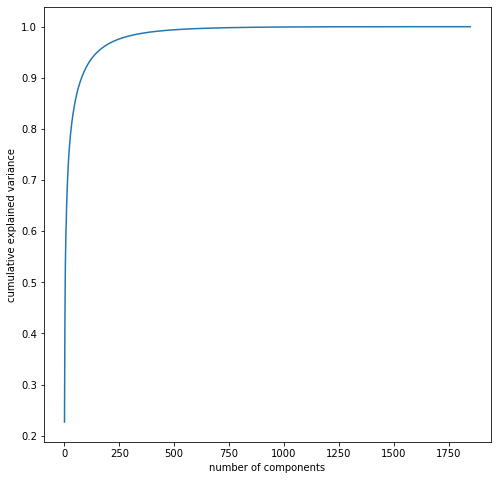

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca(X):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance at 200 components:',sum(pca.explained_variance_ratio_[0:199]) )
    
plot_pca(X)

### Class Imbalance
* A quick inspection of the target classes we are trying to predict shows this is a 43 class problem.
* In a two class problem we have at least 1/2 = 50% accuracy even when guessing.
* This multi-class problem is much more complex with only 1/43 = 2.33% accuracy when guessing.
* To make things more challenging, we also have very imbalanced classes.
* It appears that class # 11 is by far the largest class.

Total Records 2489
Total Classes: 43
Class Gini Index 0.9290543316264526
Smallest Class Id: 32 Records: 20
Largest Class Id: 11 Records: 530
Accuracy when Guessing: 2.33 %


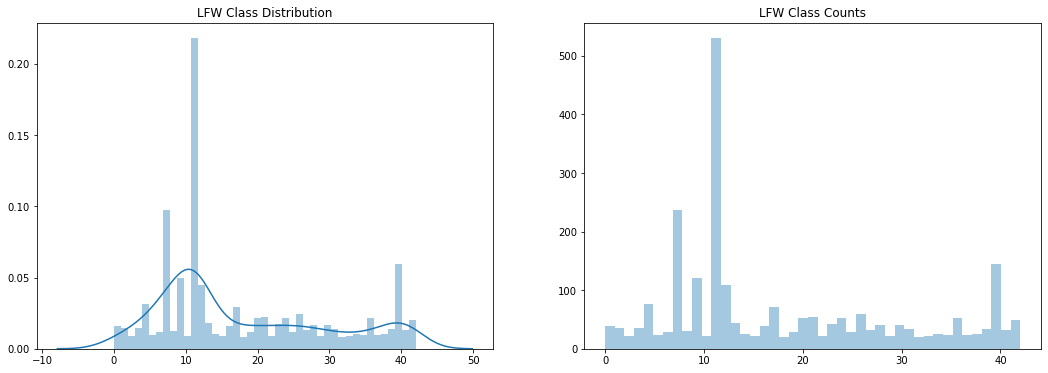

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Adapted from:
# https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/
def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_class_dist(y):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('LFW Class Distribution');
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('LFW Class Counts');
    

plot_class_dist(y)

In [7]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

### Inspecting The Confusion Matrix 
* Here I use train_test_split to divide the data into 70% training and 30% testing random samples.   
* The top performing baseline LogisticRegression model is used to make predictions against the test data. 
* Finally, I plot a confusion matrix.
 * A perfect confusion matrix will only show shaded squares across the matrix diagonal. 
* However, the confusion matrix below shows that many class predictions are getting confused with the larger classes 7, 11, 12 and 40.
* This is evident by the high number of off-diagonal shaded boxes for each column.

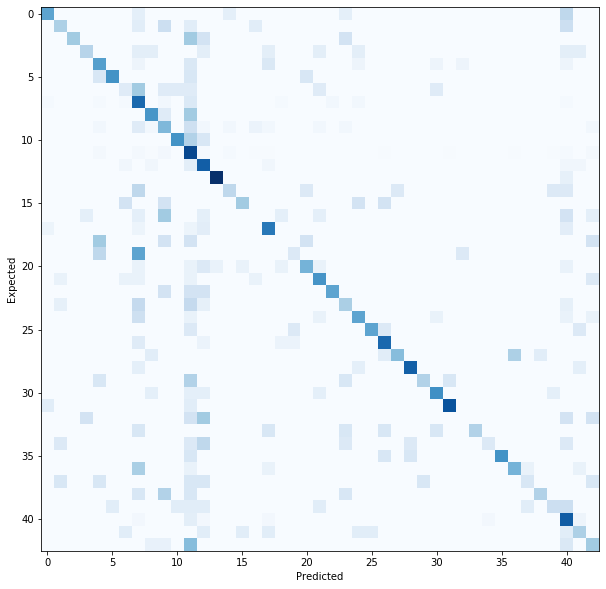

In [81]:
from sklearn.model_selection import train_test_split
from StrandSliceClassifier import StrandSliceClassifier
from sklearn.linear_model import LogisticRegression

# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Use StrandSliceClassifier to build a model and predict on the test set
strand = LogisticRegression(solver='liblinear')
strand.fit(X_train, y_train)
y_pred = strand.predict(X_test)

# Create a confusion matrix to see what classes StrandSliceClassifier is getting wrong 
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Blues'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

### Undersampling, Oversampling, and SMOTE
**In this section we use random sampling via the imblearn package to address the dataset's class imbalance problem.**
* First we undersample adjusting all classe sizes to be equal to the smallest class.
 * The dataset is reduced from 2,489 records to 860 with each class containing only 20 records.
 * This approach is not desirable, since we lost over half of our data. 
* Next we undersample the majority class only reducing class 11 from 530 to 20 records.
 * This approach is not desirable, since class 7 still has 236 records. (Multiple classes are imbalanced in the dataset)
* Finally, we use Synthetic Minority Over-sampling to over sample all classes, except the majority. 
 * This uses random sampling to increase under-represented classes to the majority size.
 * This approach could be problematic on large datasets.  In this case we increase the dataset rows from 2,489 to 22,790.

In [167]:
from imblearn.under_sampling import RandomUnderSampler

us = RandomUnderSampler()
X_us, y_us = us.fit_sample(X, y)

print('Records Selected:', len(us.sample_indices_))

Records Selected: 860


Total Records 860
Total Classes: 43
Class Gini Index 0.9767441860465116
Smallest Class Id: 42 Records: 20
Largest Class Id: 42 Records: 20
Accuracy when Guessing: 2.33 %


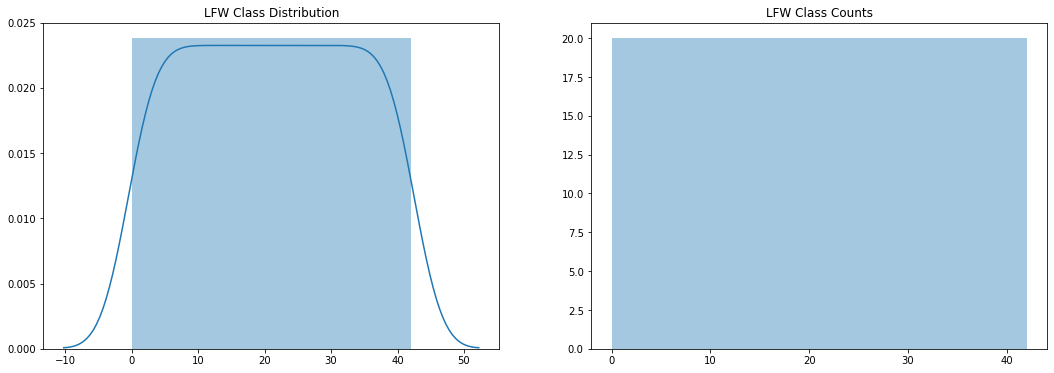

In [168]:
plot_class_dist(y_us)

In [169]:
from imblearn.under_sampling import RandomUnderSampler

us = RandomUnderSampler(sampling_strategy='majority')
X_us_maj, y_us_maj = us.fit_sample(X, y)

print('Records Selected:', len(us.sample_indices_))

Records Selected: 1979


Total Records 1979
Total Classes: 43
Class Gini Index 0.9593975755028609
Smallest Class Id: 11 Records: 20
Largest Class Id: 7 Records: 236
Accuracy when Guessing: 2.33 %


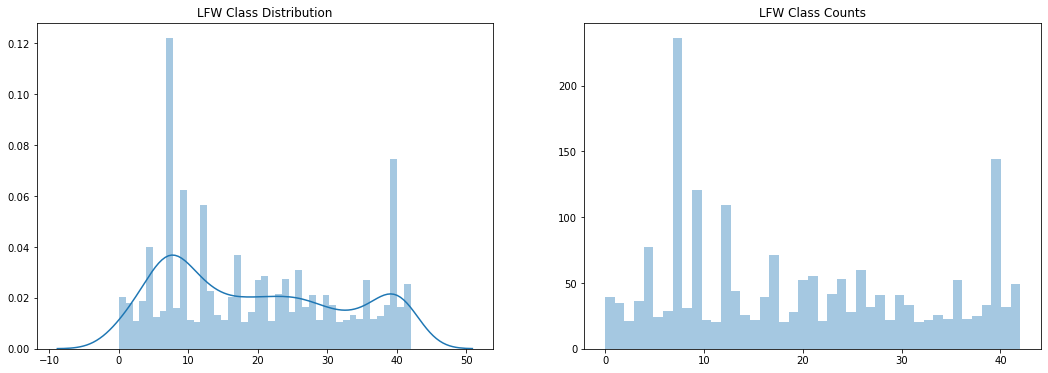

In [171]:
plot_class_dist(y_us_maj)

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='not majority')
X_sm, y_sm = sm.fit_sample(X, y)

Total Records 22790
Total Classes: 43
Class Gini Index 0.9767441860465116
Smallest Class Id: 31 Records: 530
Largest Class Id: 31 Records: 530
Accuracy when Guessing: 2.33 %


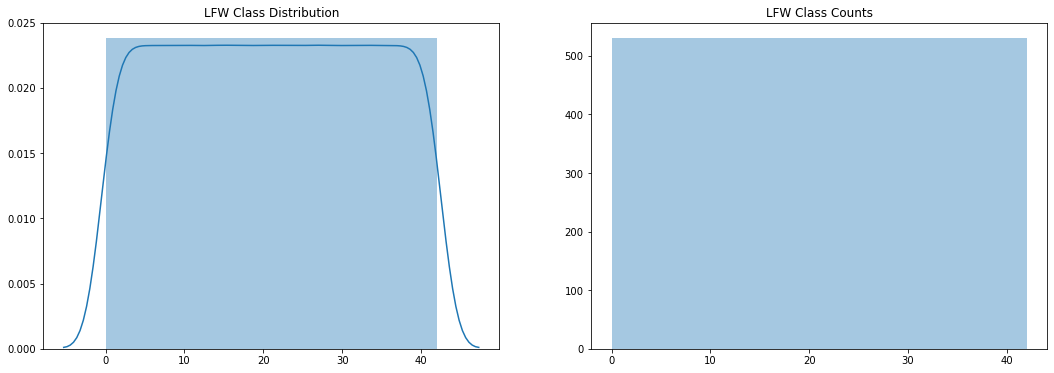

In [14]:
plot_class_dist(y_sm)

### Testing the Adjusted Datasets 
**I perform 10-fold cross validation again to see which dataset above performs best using the LogisticRegression classifier, since it had the highest accuracy originally.  The original dataset has also been scaled now, so I re-run cross validation on it as well.**
* Original Dataset Scaled - 69.38% accuracy
* Minority Undersampled Dataset - 54.06% accuracy
* Majority Undersampled Dataset - 67.61% accuracy
* Oversample all Classes to Majority Dataset - **99.34% accuracy**

In [178]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print('Original Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(LogisticRegression(), X, y, cv)
print('Minority Undersampled Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(LogisticRegression(), X_us, y_us, cv)
print('Majority Undersampled Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(LogisticRegression(), X_us_maj, y_us_maj, cv)
print('Oversample all Classes to Majority Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(LogisticRegression(), X_sm, y_sm, cv)

Original Dataset
----------------------------------------------------------------
Fold Scores:
 
[0.73895582 0.70682731 0.69879518 0.69076305 0.6626506  0.69879518
 0.64257028 0.69477912 0.66666667 0.73790323]
 
Mean Accuracy:  0.6938706438657858
Mean Fit Time:  13.302919864654541
Mean Score Time:  0.010057830810546875
CV Time:  22.023164987564087
Minority Undersampled Dataset
----------------------------------------------------------------
Fold Scores:
 
[0.59302326 0.53488372 0.52325581 0.56976744 0.51162791 0.47674419
 0.5        0.53488372 0.5        0.6627907 ]
 
Mean Accuracy:  0.5406976744186047
Mean Fit Time:  8.115061068534851
Mean Score Time:  0.004802727699279785
CV Time:  11.942819118499756
Majority Undersampled Dataset
----------------------------------------------------------------
Fold Scores:
 
[0.7020202  0.66161616 0.71212121 0.65656566 0.72222222 0.63131313
 0.66666667 0.60606061 0.68181818 0.72081218]
 
Mean Accuracy:  0.6761216223145158
Mean Fit Time:  11.469553327

### Using PCA to Reduce Dataset Size Number of Features
* Here we take the SMOTE oversampled dataset and perform Principal Component Analisys to reduce its' size.
* Plotting PCA components for all features in the dataset we see that selecting only 200 out of 1850 components will still get us 97.42% of the cumulative variance in this dataset. 
* Reducing the dataset from 1850 features to only 200 principal component features will save a lot of processing time later, if the smaller dataset still performs well.   

Cumulative Explained variance at 200 components: 0.974024432580336


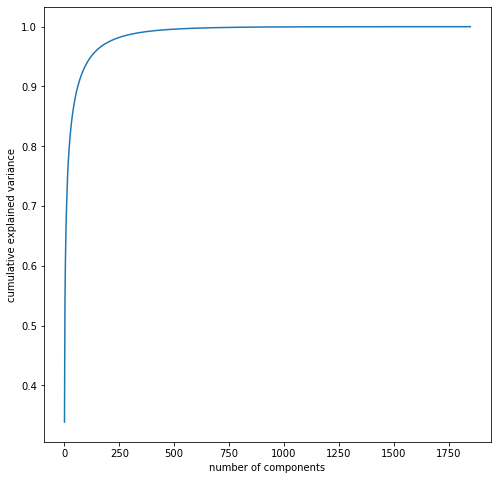

In [15]:
plot_pca(X_sm)

### Testing the 200 Component Dataset
* The PCA reduced dataset still achieves 99.17% accuracy.  The original SMOTE dataset 99.34%.
* PCA allows us to give up 1650 columns of data in this case for a cost 0.17% accuracy.  This seems like an acceptable tradeoff. 
* PCA also removes correlations from columns within a dataset.  This is an added benefit, since we are classifying image data and should help some of our classifiers perform better.

In [16]:
from sklearn.model_selection import StratifiedKFold

# Convert X_sm to 200 principal components
pca = PCA(n_components=200)
X_sm_pca200 = pca.fit_transform(X_sm)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print('Oversample all Classes to Majority Dataset @ 200 Principal Components')
print('----------------------------------------------------------------')
stratified_cross_validate(LogisticRegression(), X_sm_pca200, y_sm, cv)

Oversample all Classes to Majority Dataset @ 200 Principal Components
----------------------------------------------------------------
Fold Scores:
 
[0.98683633 0.99429574 0.98859149 0.99254059 0.99034664 0.98990785
 0.99385695 0.98990785 0.98859149 0.99297938]
 
Mean Accuracy:  0.9907854322071084
Mean Fit Time:  17.934167361259462
Mean Score Time:  0.01330568790435791
CV Time:  31.43050217628479


### Getting the New Baselines for all Models
**Here we recalulate our accuracy baselines for each model.** 
* At this point Strand classifiers are still unable to make classifications on this data until it is Strand Vectorized. 

In [192]:
# Recreate our baseline accuracy
test_models(X_sm_pca200,y_sm)

StrandSliceClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.02540268898010254
Mean Score Time:  0.0
CV Time:  1.9503300189971924
 
StrandGiniClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.028809237480163574
Mean Score Time:  0.0
CV Time:  0.2344651222229004
 
StrandBinaryClassifier
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.026245617866516115
Mean Score Time:  0.0
CV Time:  0.20824933052062988
 
MultinomialNB
--------------------------------
Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.04861044883728027
Mean Score Time:  0.0
CV Time:  0.24827909469604492
 
SGDClassifier
--------------------------------
Fold Scores:
 
[0.88810882 0.90785432 0.90039491 0.89732339 0.906

## Strand Vectorize the balanced LFW Dataset
**Now that we have a nicer baseline accuracy.  Let's see how StrandPy tools handle this dataset.**

In [17]:
%%time 
from StrandPy import StrandVectorizer

# StrandVectorizer only accepts a Pandas dataframe as input to
# best inspect column data types for transformation.
X_sm_pca200_df = pd.DataFrame(X_sm_pca200)

sv = StrandVectorizer(truncate_to=10,signature_length=None, analyzer='word', ngram_range=(1,1)
                      , binary=False, use_idf=False, norm=None)
X_sv = sv.fit_transform(X_sm_pca200_df)
X_sv

Wall time: 46.4 s


<22790x4551796 sparse matrix of type '<class 'numpy.float64'>'
	with 4558000 stored elements in Compressed Sparse Row format>

# Testing the Strand Vectorized Dataset for a Baseline Accuracy
* This version of the Strand Vectorized dataset produces 27.07% accuracy during 10-fold cross validation. 
* Currently the Strand classifier is below the best classifier tested which was at 66.45%.

In [20]:
%%time
from StrandPy import StrandBinaryClassifier

strand = StrandBinaryClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_sv, y_sm, cv)

Fold Scores:
 
[0.02852128 0.02544976 0.02939886 0.02544976 0.02544976 0.02808249
 0.02676613 0.02939886 0.02413339 0.02632734]
 
Mean Accuracy:  0.02689776217639316
Mean Fit Time:  19.101768708229066
Mean Score Time:  0.6343705415725708
CV Time:  33.337400674819946
Wall time: 33.3 s


In [21]:
%%time
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_sv, y_sm, cv)

Fold Scores:
 
[0.02808249 0.02501097 0.0276437  0.02501097 0.02501097 0.02588855
 0.02501097 0.02852128 0.02281703 0.02501097]
 
Mean Accuracy:  0.025800789820096537
Mean Fit Time:  0.7326058149337769
Mean Score Time:  1.6649063110351563
CV Time:  4.330974340438843
Wall time: 4.33 s


### Finding the Best truncate_to Parameters for the Breast Cancer Dataset
**Below, I check each column for the best truncate_to parameters**
* This process is experimental and took 37.1s
* We can see when looking at each of the individual trun_parms that different values are required to find the best separation of the classes.
* This is a feature that could easily be incorporated into the StrandVectorizer once it is perfected.  

In [22]:
%%time
from sklearn.model_selection import cross_val_score

# Create one truncate parameter for each continuous field
# Each value starts at 10 
trun_parms = [10] * X_sm_pca200_df.shape[1] 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Test the trunc value for each column 
for c in range(X_sm_pca200_df.shape[1]):
    scores = []
    
    for i in range(10):
        # Test possible truncate_to values for each individual column
        trun_parms[c] = i
        sv = StrandVectorizer(truncate_to=trun_parms,signature_length=None, analyzer='word', ngram_range=(1,1)
                          , binary=False, use_idf=False, norm=None)
        X_sv = sv.fit_transform(X_sm_pca200_df)
        # Perform cross validation to find the best value parameter for each column 
        estimator = StrandSliceClassifier()
        scores.append(np.mean(cross_val_score(estimator, X_sv, y_sm, cv=cv, n_jobs=-1, scoring='accuracy')))
        
    # Find the parm with the max score
    best_parm = scores.index(max(scores))
    #Use this parameter for this column
    trun_parms[c] = best_parm 
    
np.array(trun_parms)

Wall time: 20h 46min 1s


array([4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 5, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7,
       1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 6, 1, 0, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 6, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 6, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 6, 2, 2, 2,
       1, 1])

In [1]:
trun_parms = [4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 5, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7,
       1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 6, 1, 0, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 6, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 6, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 6, 2, 2, 2,
       1, 1]

In [18]:
sv = StrandVectorizer(truncate_to=trun_parms,signature_length=None, analyzer='word', ngram_range=(1,1)
                          , binary=False, use_idf=False, norm=None)
X_sv = sv.fit_transform(X_sm_pca200_df)
X_sv

<22790x187358 sparse matrix of type '<class 'numpy.float64'>'
	with 4558000 stored elements in Compressed Sparse Row format>

In [20]:
from StrandPy import StrandSliceClassifier

strand = StrandSliceClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cross_validate(strand, X_sv, y_sm, cv)

Fold Scores:
 
[0.49275998 0.48266784 0.50416849 0.4681878  0.48310663 0.48530057
 0.48837209 0.4839842  0.48705573 0.49100483]
 
Mean Accuracy:  0.4866608161474331
Mean Fit Time:  0.7585675477981567
Mean Score Time:  0.6791712045669556
CV Time:  3.3022758960723877


In [21]:
%%time

# StrandPy Tools
from StrandPy import StrandSliceClassifier
from StrandPy import CVFE
# Sklean Tools 
from sklearn.model_selection import StratifiedKFold

# Get feature importances
strand = StrandSliceClassifier(feature_importances=True)
strand.fit(X_sv, y_sm)
feature_importances = strand.feature_importances_

# Create faster, no-feature_importances strand object 
strand = StrandSliceClassifier()

# Use Sklearn's StratifiedKFold to manage cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create CVFE object using feature_importances created earlier 
cvfe = CVFE(strand, cv, n_jobs=-1, min_step_size=1, scoring='accuracy',
            preserve_increases=True, feature_importances=feature_importances, verbose=True)

cvfe.fit(X_sv, y_sm)

X Shape:  (22790, 187358)
-----------------------------------------------------
Remove Low Nonzero Features...
X Shape: (22790, 187358)
Current Base Score:  0.49579
Step Features Removed:  148641
Total Features Removed:  148641
Cross Validations:  616
-----------------------------------------------------
Remove Features by Importances...
X Shape: (22790, 38717)
Current Base Score:  0.49588
Step Features Removed:  52
Total Features Removed:  148693
Cross Validations:  715
-----------------------------------------------------
X Shape: (22790, 38665)
Current Base Score:  0.49588
Step Features Removed:  1
Total Features Removed:  148694
Cross Validations:  718
Step size:  19332
Step Blocks removed: 5.172770535899027e-05
-----------------------------------------------------
X Shape: (22790, 38664)
Current Base Score:  0.49588
Step Features Removed:  8
Total Features Removed:  148702
Cross Validations:  727
Step size:  4832
Step Blocks removed: 0.0016556291390728477
-------------------------

CVFE(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
     estimator=StrandSliceClassifier(feature_importances=False,
                                     noise_thresh=None),
     feature_importances=array([0.01164985, 0.01164985, 0.01167179, ..., 0.01164985, 0.01164985,
       0.01164985]),
     min_step_size=1, n_jobs=-1, preserve_increases=True, scoring='accuracy',
     verbose=True)

In [22]:
stratified_cross_validate(strand, cvfe.transform(X_sv), y_sm, cv)

Fold Scores:
 
[0.61693725 0.60991663 0.61211057 0.60596753 0.6151821  0.61693725
 0.59543659 0.61211057 0.60026327 0.60421237]
 
Mean Accuracy:  0.6089074155331288
Mean Fit Time:  0.39143297672271726
Mean Score Time:  0.08281702995300293
CV Time:  0.9590508937835693


## A Note on Strand Vectorizer Benefits and Enhancements
* Strand Vectorizer benefits are not fully expressed in this notebook.  
* This is the only tool I know of that would be capable of vectorizing and classifiying a single "mixed type" dataset containing documents, gene sequences, numeric, and categorical data.  
* I also believe that the Strand Vectorizer may represent a new paradigm in feature engineering.  For example, I was able to turn 30 features into 15,340 and then narrow that down to only 173 features that were best suited for the StrandSliceClassifier.
* Once features are transformed into this space, the StrandSliceClassifier outperforms the other classifiers tested in both speed and accuracy in many cases.
* In the last example here, it does not.  I think this has something to do with the way bins are created for numeric features. However, this requires a lot more research and work. I have plenty of ideas.
* The other piece of work that remains is performing automated selection of the bin sizes i.e. the truncate_to parameter.  However, under other bin selection techniques this would go away entirely.  